In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import Nucleation_Dynamics as nd
from extensisq import BS5, SSV2stab, Pr9, CK5, CFMR7osc, Pr7
import scienceplots
import Nucleation_Dynamics as nd

  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
from diffeqpy import de, ode

In [3]:
plt.style.use(['science','ieee'])

In [5]:
# Chromium 
# Ejemplo de uso de la clase
params = {
    'temperature': 668,
    'activation_energy': 52920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 51.9961,
    'mass_density': 7.19,
    'melting_point': 2130,
    'heat_fusion': 20.48 * 1e3,
    'supersaturation_ratio': 1.1,
    'sigma': 2.0, 
    'method': 'melting'
}

cluster_physics = nd.ClusterPhysics(params)

print(f"Critical radius: {cluster_physics.critical_radius}")
print(f"Critical Gibbs free energy: {cluster_physics.critical_energy_barrier}")
print(f"Critical number of atoms: {cluster_physics.critical_number_of_molecules}")


Critical radius: 2.057804676188286e-09 meter
Critical Gibbs free energy: 3.547536761412314e-17 joule
Critical number of atoms: 3039.5555945662086 dimensionless


In [4]:
cluster_physics.number_density_equilibrium(500)   

NameError: name 'cluster_physics' is not defined

In [4]:
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

cluster_physics = nd.ClusterPhysics(params)

print(f"Critical radius: {cluster_physics.critical_radius}")
print(f"Critical Gibbs free energy: {cluster_physics.critical_energy_barrier}")
print(f"Critical number of atoms: {cluster_physics.critical_number_of_molecules}")

Critical radius: 8.184545454545456e-10 meter
Critical Gibbs free energy: 4.2089037887339014e-19 joule
Critical number of atoms: 23.04237422754489 dimensionless


In [11]:
cluster_physics.molar_volume.to("meter**3/mole")

6.002000000000001e-05 <Unit('meter ** 3 / mole')>

In [12]:
MAX_NUMBER_MOLECULES = int(3e4)
number_clusters_start = 3
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e4

In [13]:
dt

8.783832320639043e+19

In [6]:
sim = nd.JuliaClusterDynamics(params,int(1e6),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method = de.Tsit5(), rtol = 1e-5, atol = 1e-5)


: 

In [7]:
sim = nd.ScipyClusterDynamics(params,int(2e5),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim.simulate(method=Pr7, t_eval=None, rtol=1e-9, atol=1e-9, max_step = 100*dt)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/extensisq/common.py:452: UserWarning: Your problem has a real dominant root and is diagnosed as stiff.  You should probably change to a code intended for stiff problems.
  warn('Your problem has a real dominant root '


In [7]:
us = de.stack(sim.sol.u)

/home/alexandre_sureda/miniconda3/envs/neutronics/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


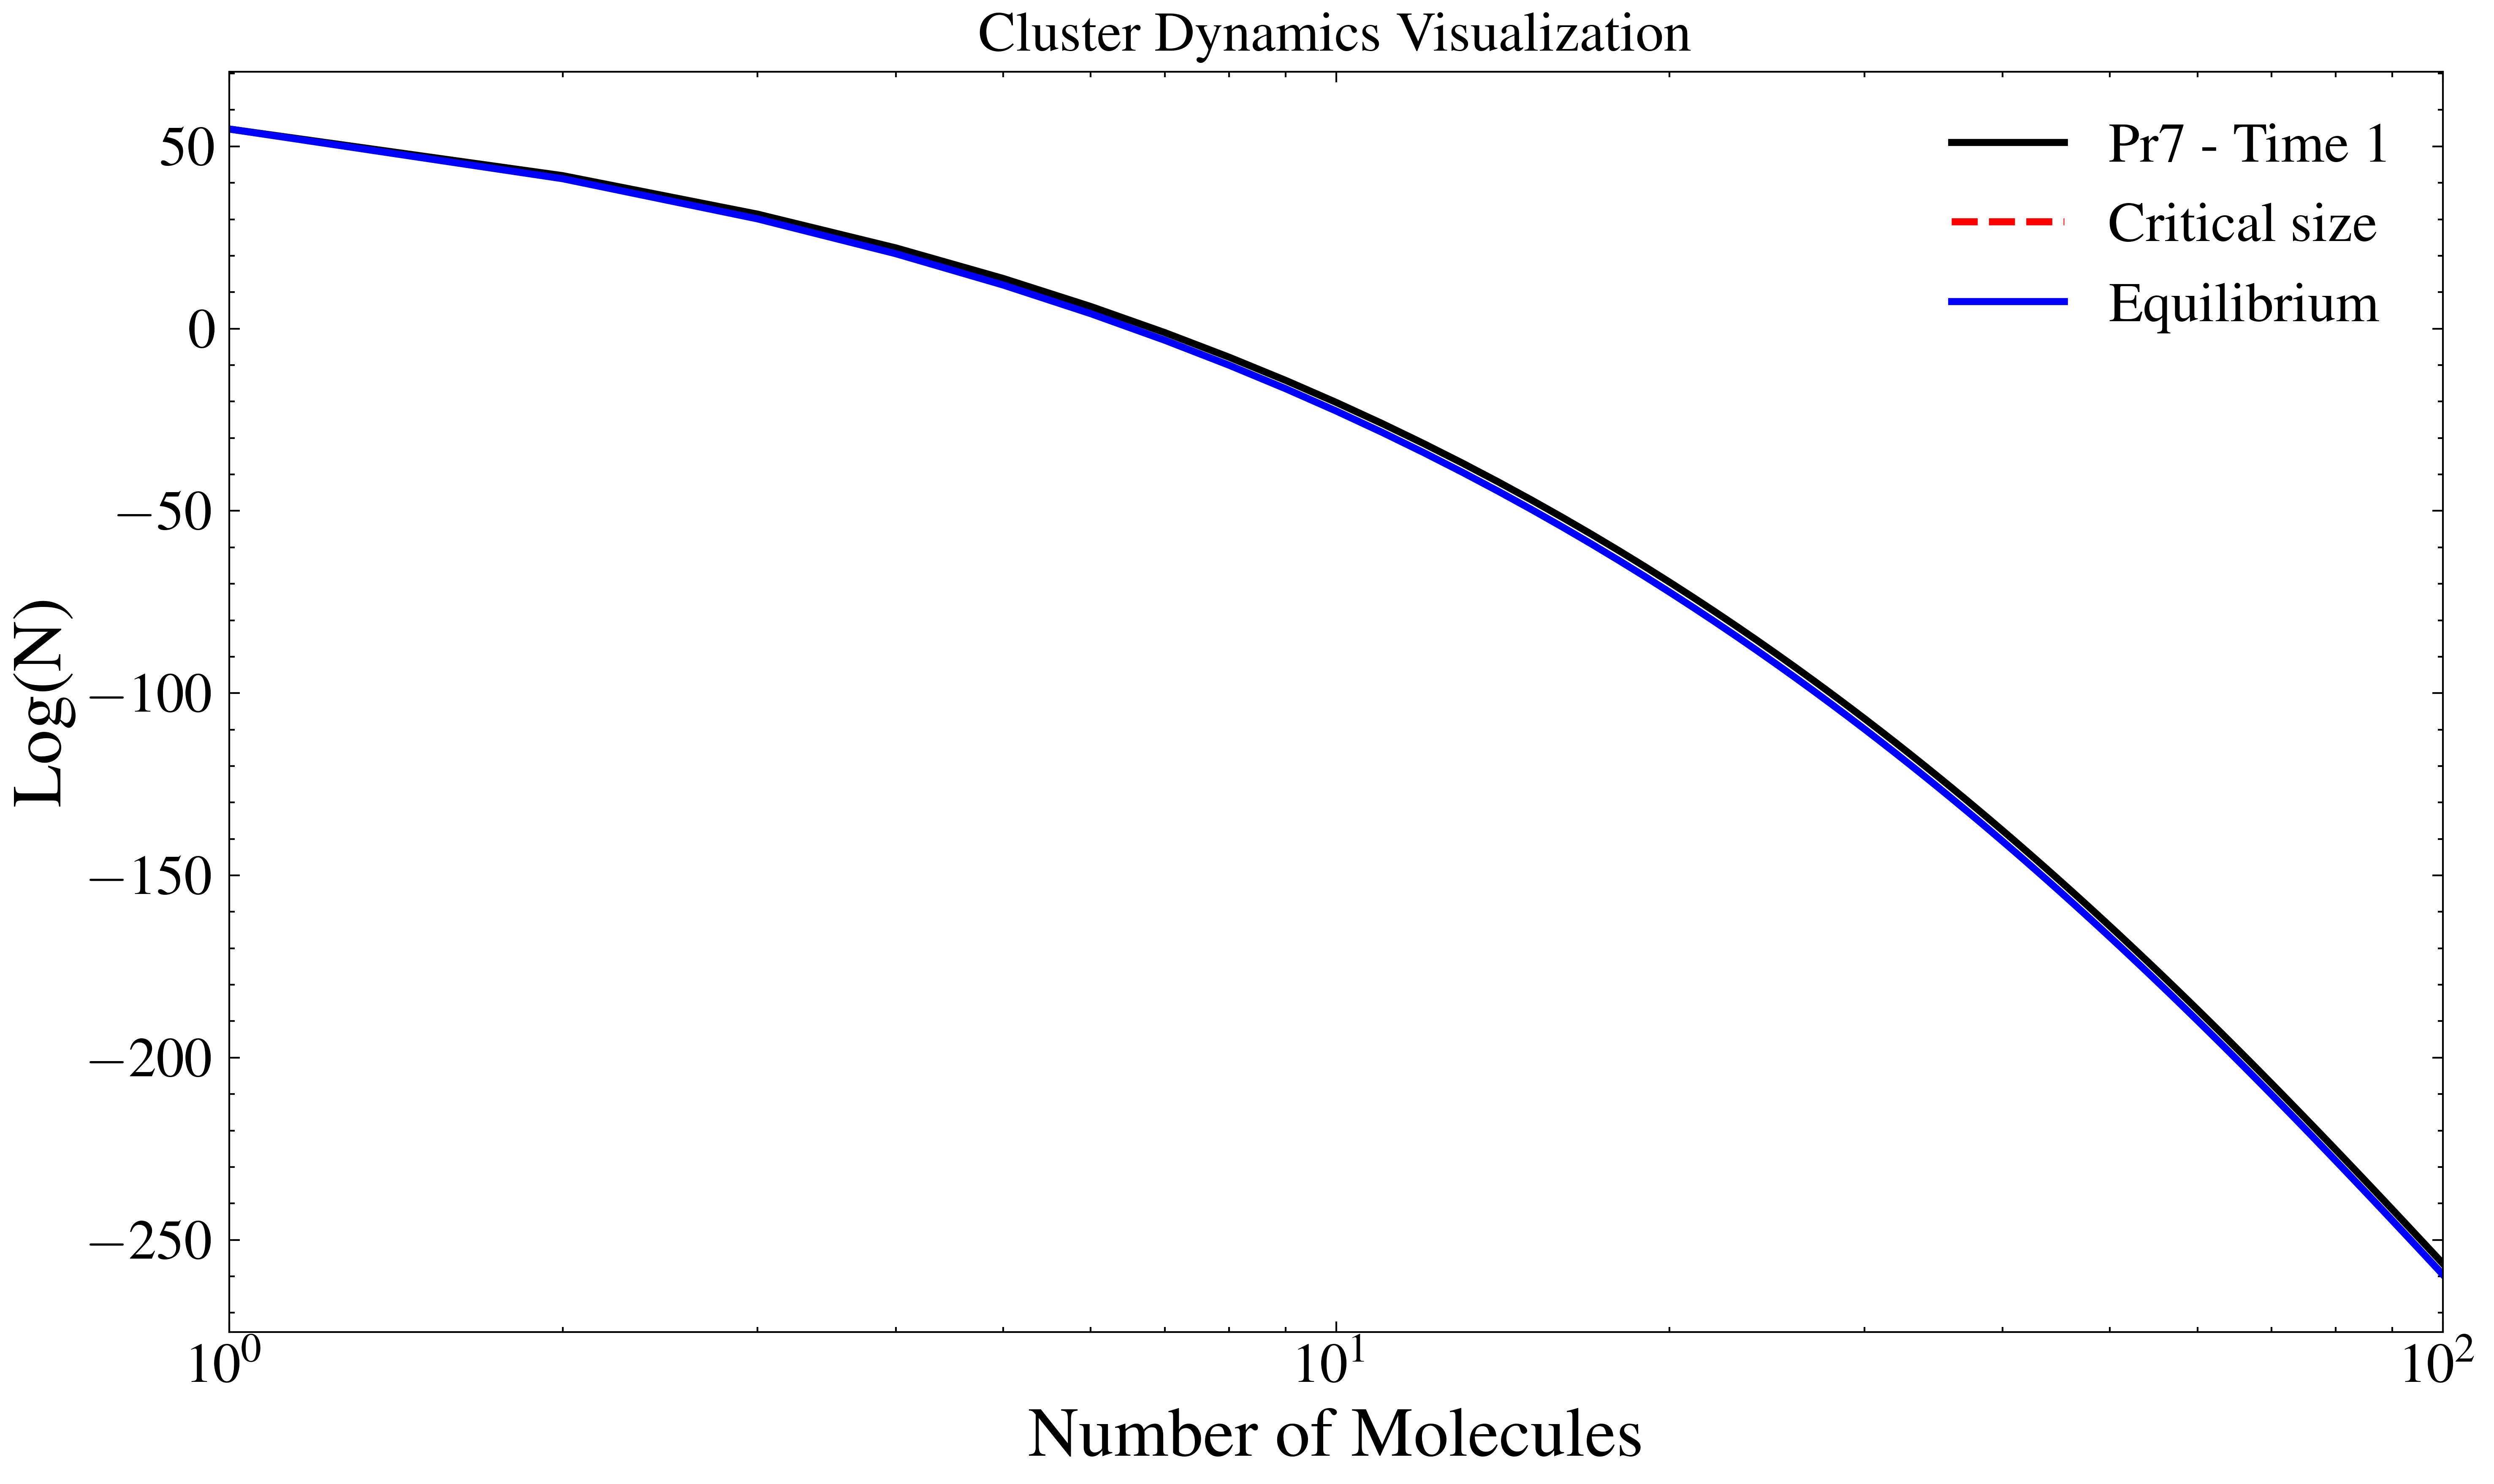

In [11]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 6))  # Tamaño adecuado para detalles y legibilidad

# Suponiendo que 'sim' y 'cluster_physics' ya están definidos y contienen los datos necesarios

# Genera los plots
plt.plot(sim.number_molecules_array, np.log(us[:,-1] ), label='Pr7 - Time 1', linewidth=2)

# Línea del tamaño crítico
plt.axvline(x=cluster_physics.critical_number_of_molecules, color='red', linestyle='--', linewidth=2, label='Critical size')

n = np.linspace(1,100,int(100))
# Curva de equilibrio
plt.plot(n, np.log(cluster_physics.number_density_equilibrium(n).magnitude ), label='Equilibrium', color='blue', linestyle='-', linewidth=2)

# Personalización de la gráfica
plt.xlabel('Number of Molecules', fontsize=20)
plt.ylabel('Log(N)', fontsize=20)
plt.title('Cluster Dynamics Visualization', fontsize=16)
#plt.xscale('log')
plt.xlim(1, 100)
#plt.ylim(-60, 0)
plt.legend(fontsize=16, loc='upper right')  # Ajusta la ubicación según necesidad
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()  # Ajusta automáticamente los parámetros de la figura para dar un padding adecuado

# Guarda la figura
plt.xscale('log')
plt.show()



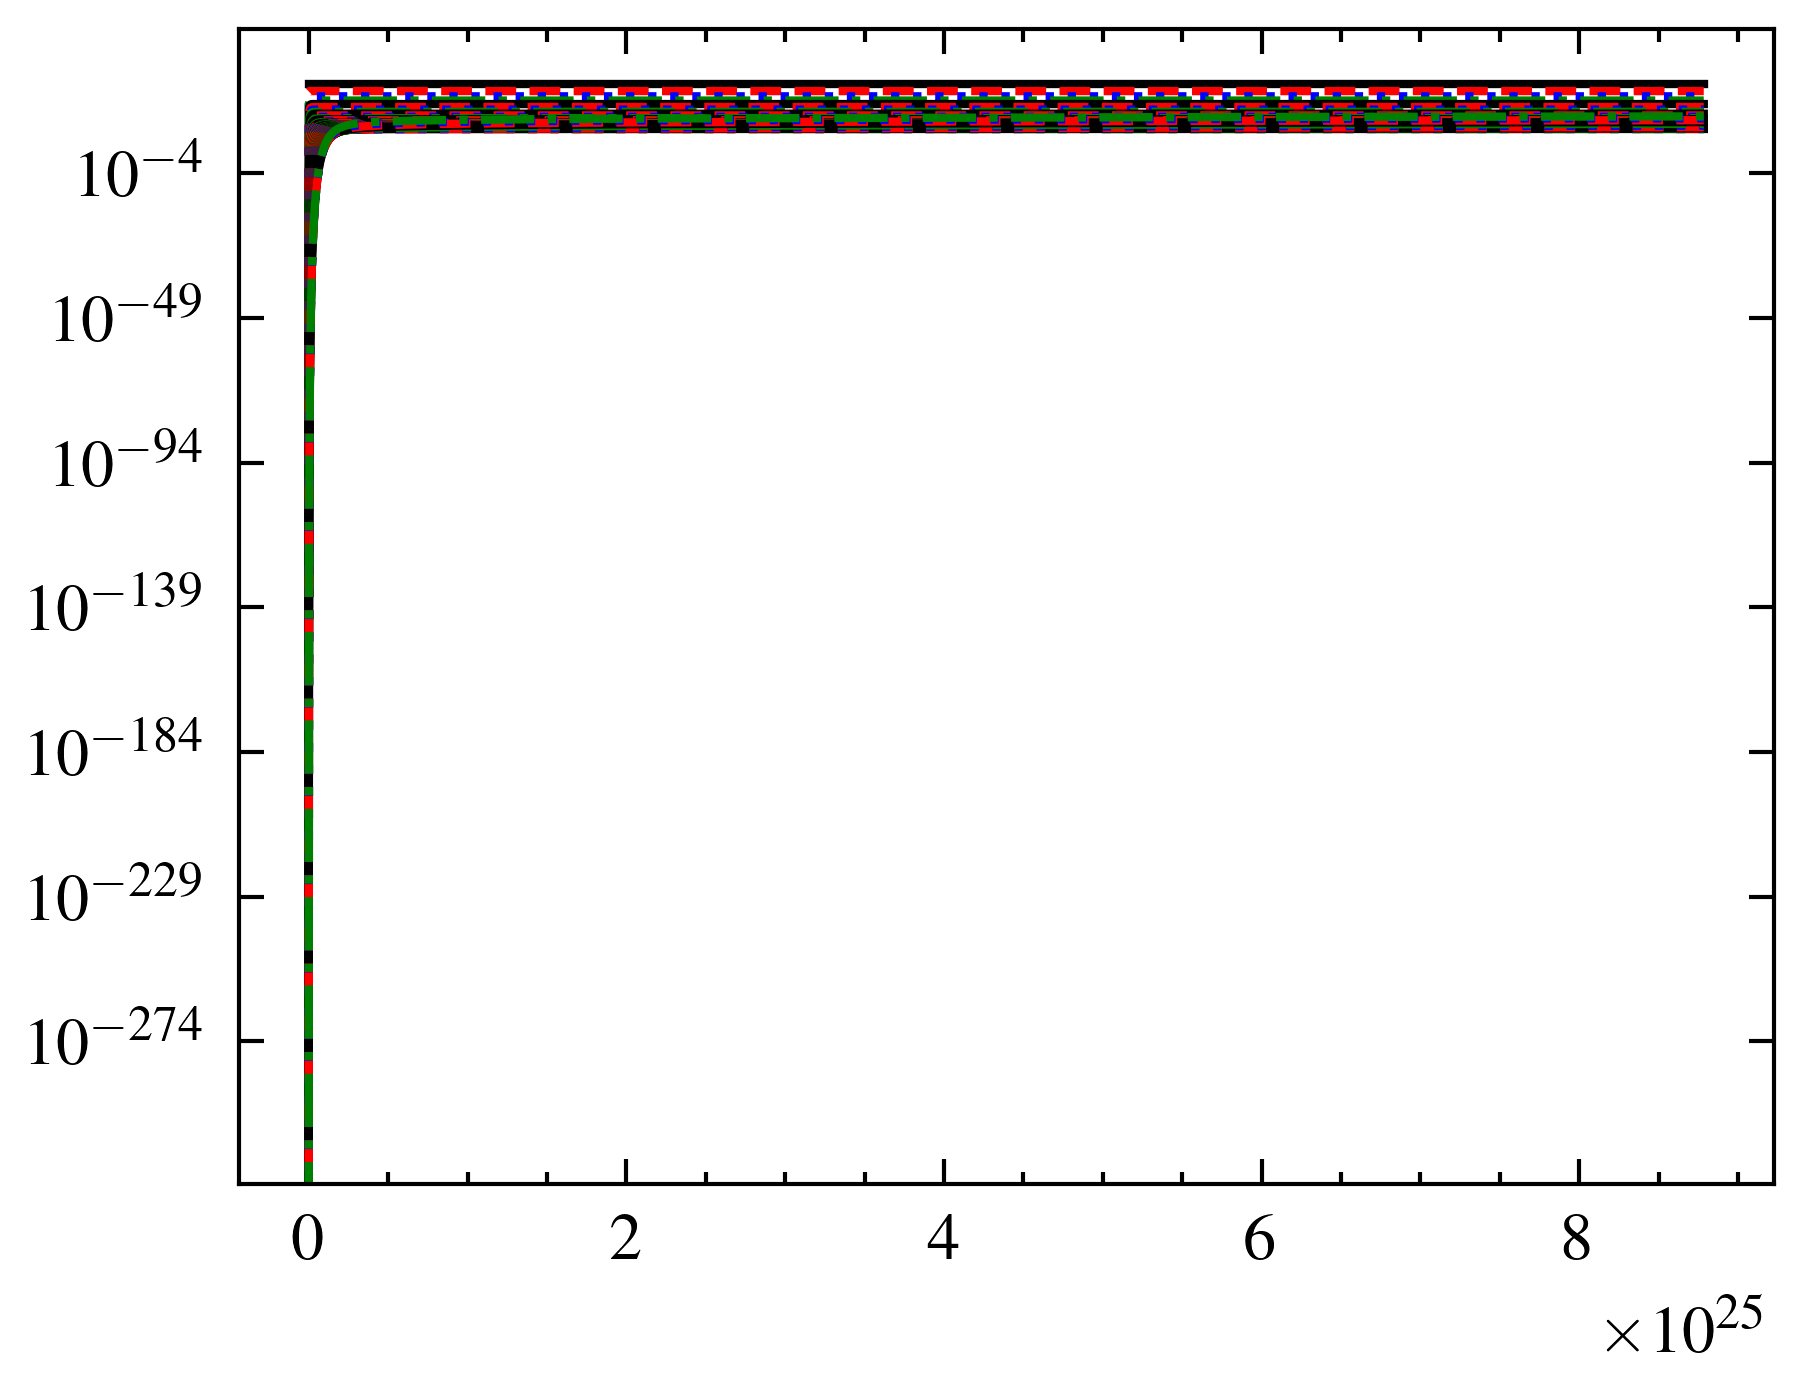

In [9]:
plt.plot(sim.sol.t, de.transpose(de.stack(sim.sol.u)))
plt.yscale('log')

In [6]:
sim2 = nd.ScipyClusterDynamics(params,int(1e6),dt, number_clusters_start, MAX_NUMBER_MOLECULES)
sim2.simulate(method='BDF', t_eval=None, rtol=1e-5, atol=1e-5)


/tmp/ipykernel_8577/3094418344.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 1] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 1', linewidth=2)
/tmp/ipykernel_8577/3094418344.py:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 5] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 5', linewidth=2)
/tmp/ipykernel_8577/3094418344.py:12: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 10] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 10', linewidth=2)
/tmp/ipykernel_8577/3094418344.py:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 20] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 20', linewidth=2)
/tmp/ipykernel_8577/3094418344.py:14: RuntimeWarning: divide by zero

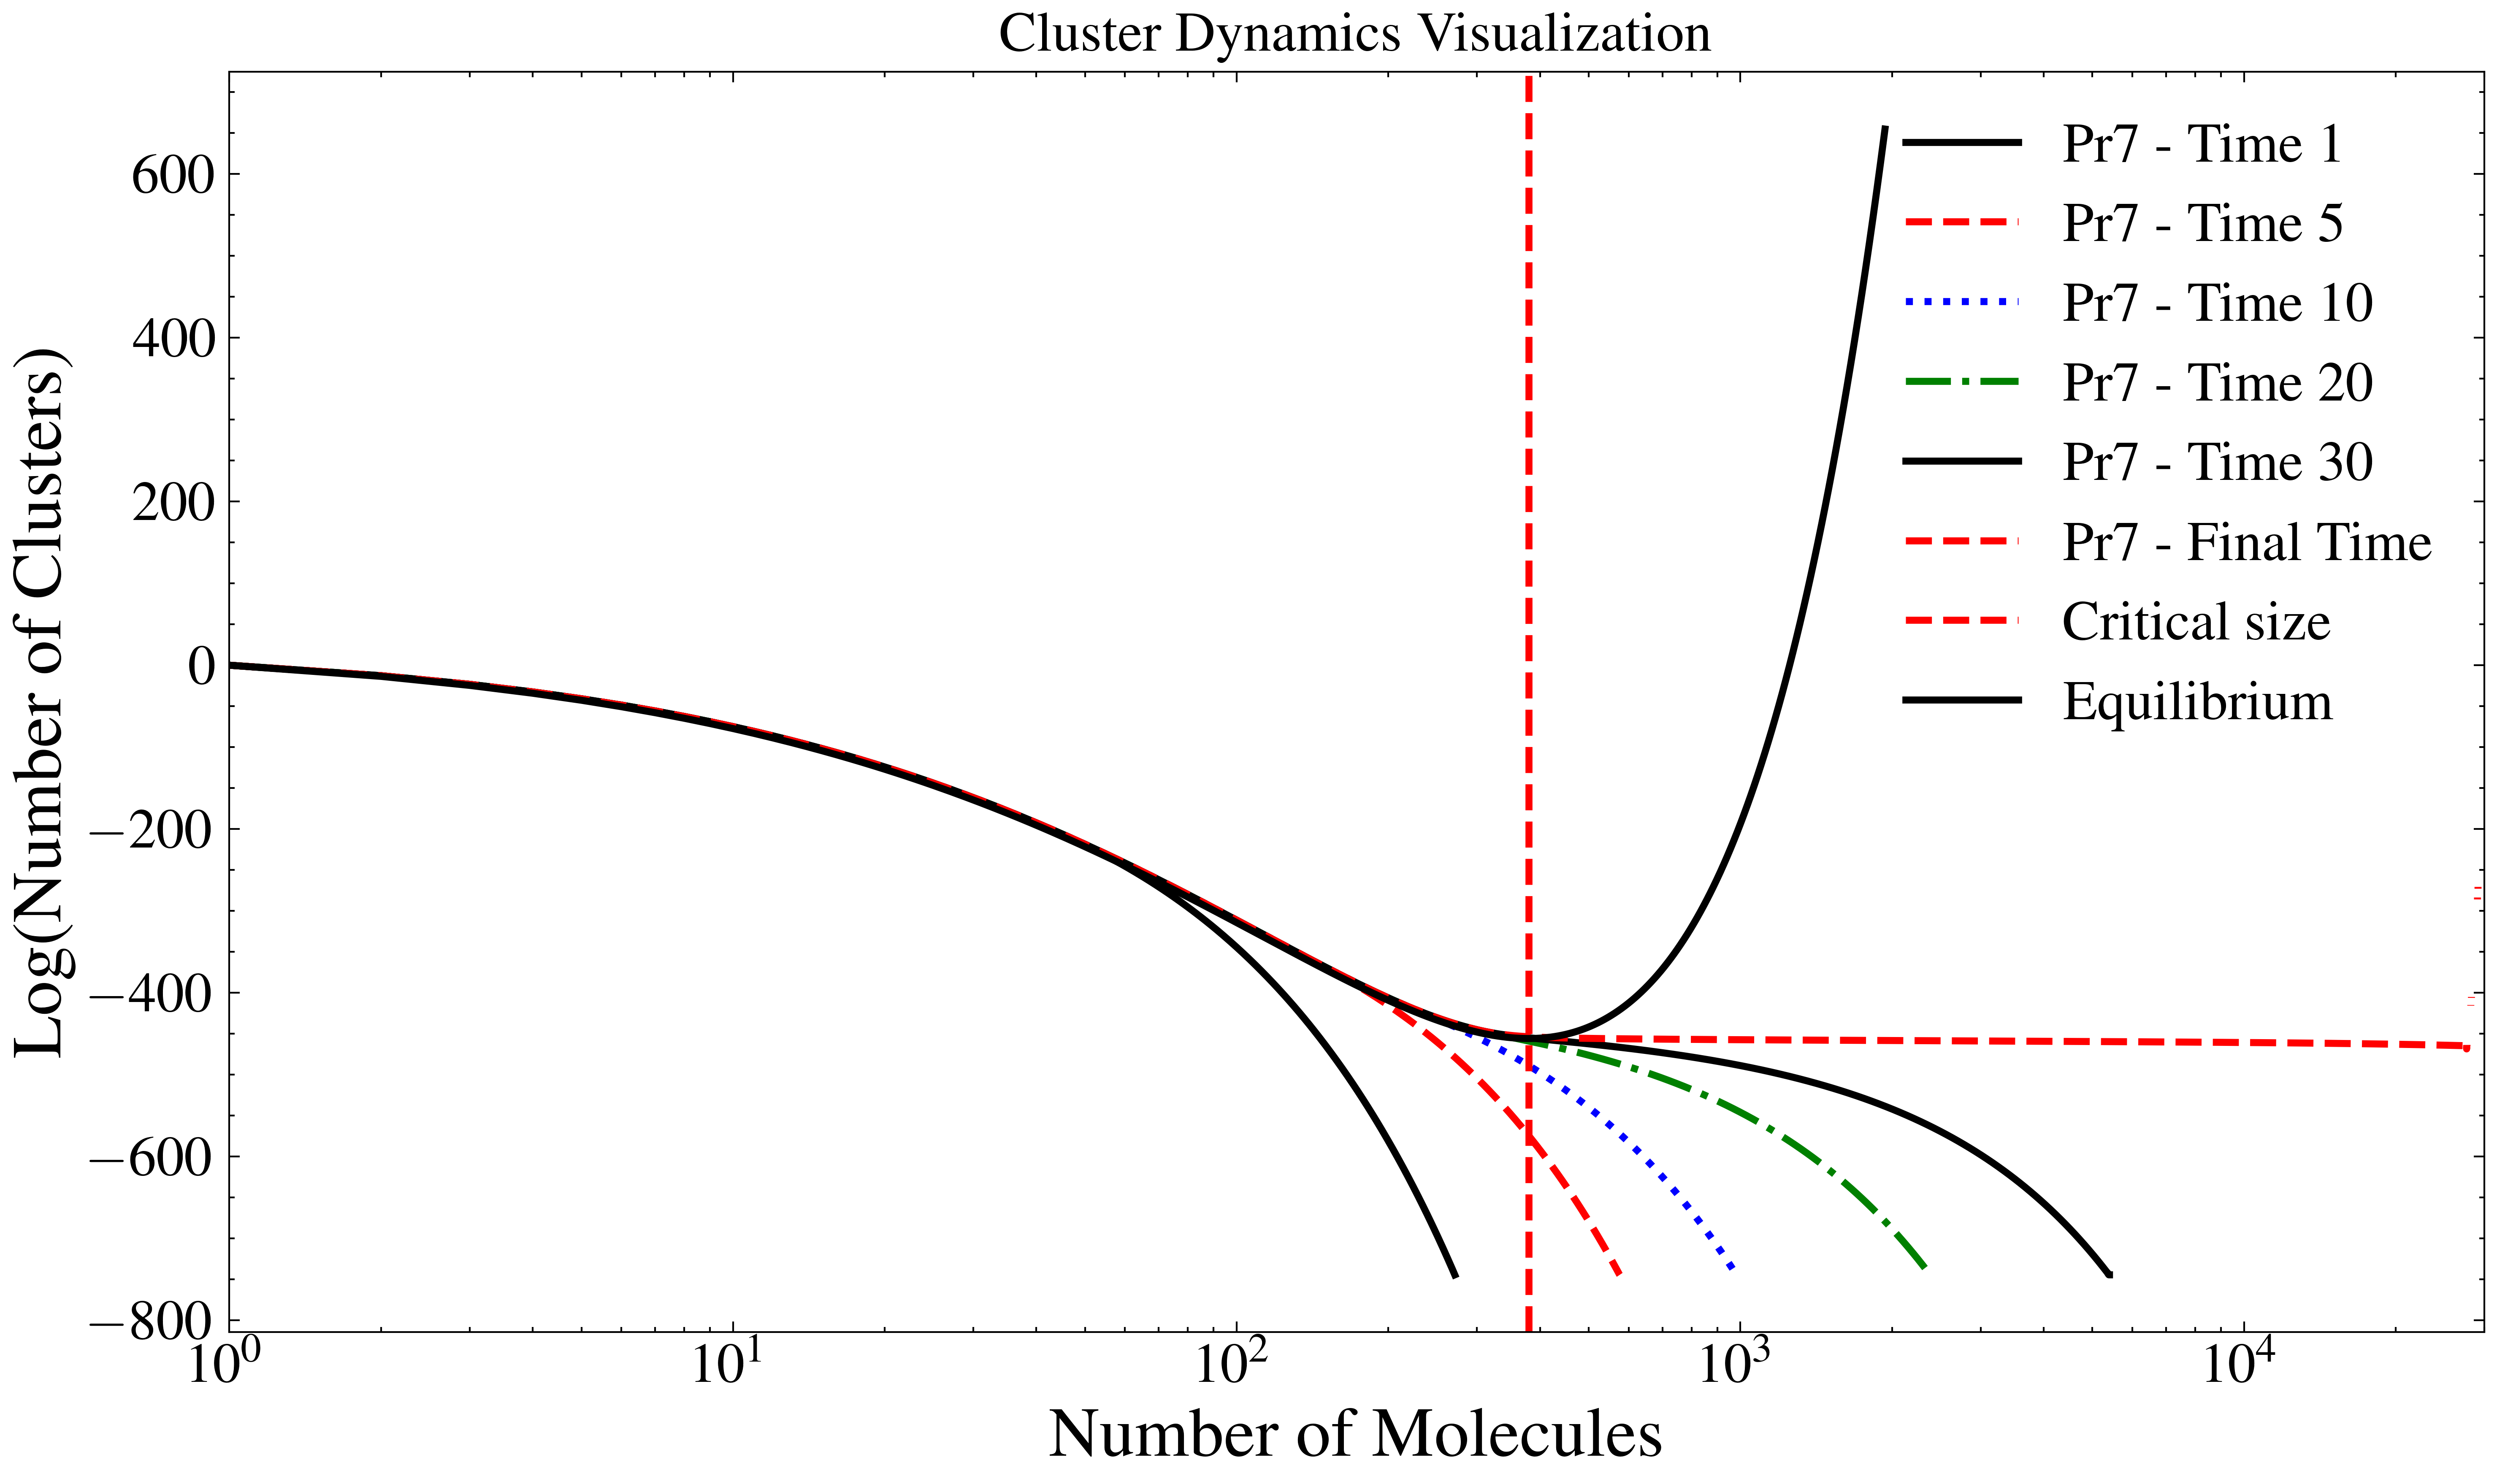

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 6))  # Tamaño adecuado para detalles y legibilidad

# Suponiendo que 'sim' y 'cluster_physics' ya están definidos y contienen los datos necesarios

# Genera los plots
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 1] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 1', linewidth=2)
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 5] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 5', linewidth=2)
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 10] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 10', linewidth=2)
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 20] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 20', linewidth=2)
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, 30] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Time 30', linewidth=2)
plt.plot(sim.number_molecules_array, np.log(sim.cluster_array[:, -1] / cluster_physics.AVOGADRO.magnitude), label='Pr7 - Final Time', linewidth=2, linestyle="--")

# Línea del tamaño crítico
plt.axvline(x=cluster_physics.critical_number_of_molecules, color='red', linestyle='--', linewidth=2, label='Critical size')

n = np.linspace(1,3e4,int(3e4))
# Curva de equilibrio
plt.plot(n, np.log(cluster_physics.number_density_equilibrium(n).magnitude / cluster_physics.AVOGADRO.magnitude), label='Equilibrium', color='black', linestyle='-', linewidth=2)

# Personalización de la gráfica
plt.xlabel('Number of Molecules', fontsize=20)
plt.ylabel('Log(Number of Clusters)', fontsize=20)
plt.title('Cluster Dynamics Visualization', fontsize=16)
plt.xscale('log')
plt.xlim(1, 3e4)
#plt.ylim(-60, 0)
plt.legend(fontsize=16, loc='upper right')  # Ajusta la ubicación según necesidad
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()  # Ajusta automáticamente los parámetros de la figura para dar un padding adecuado

# Guarda la figura
plt.savefig('cluster_dynamics.png', dpi=300)  # dpi alto para alta resolución

plt.show()


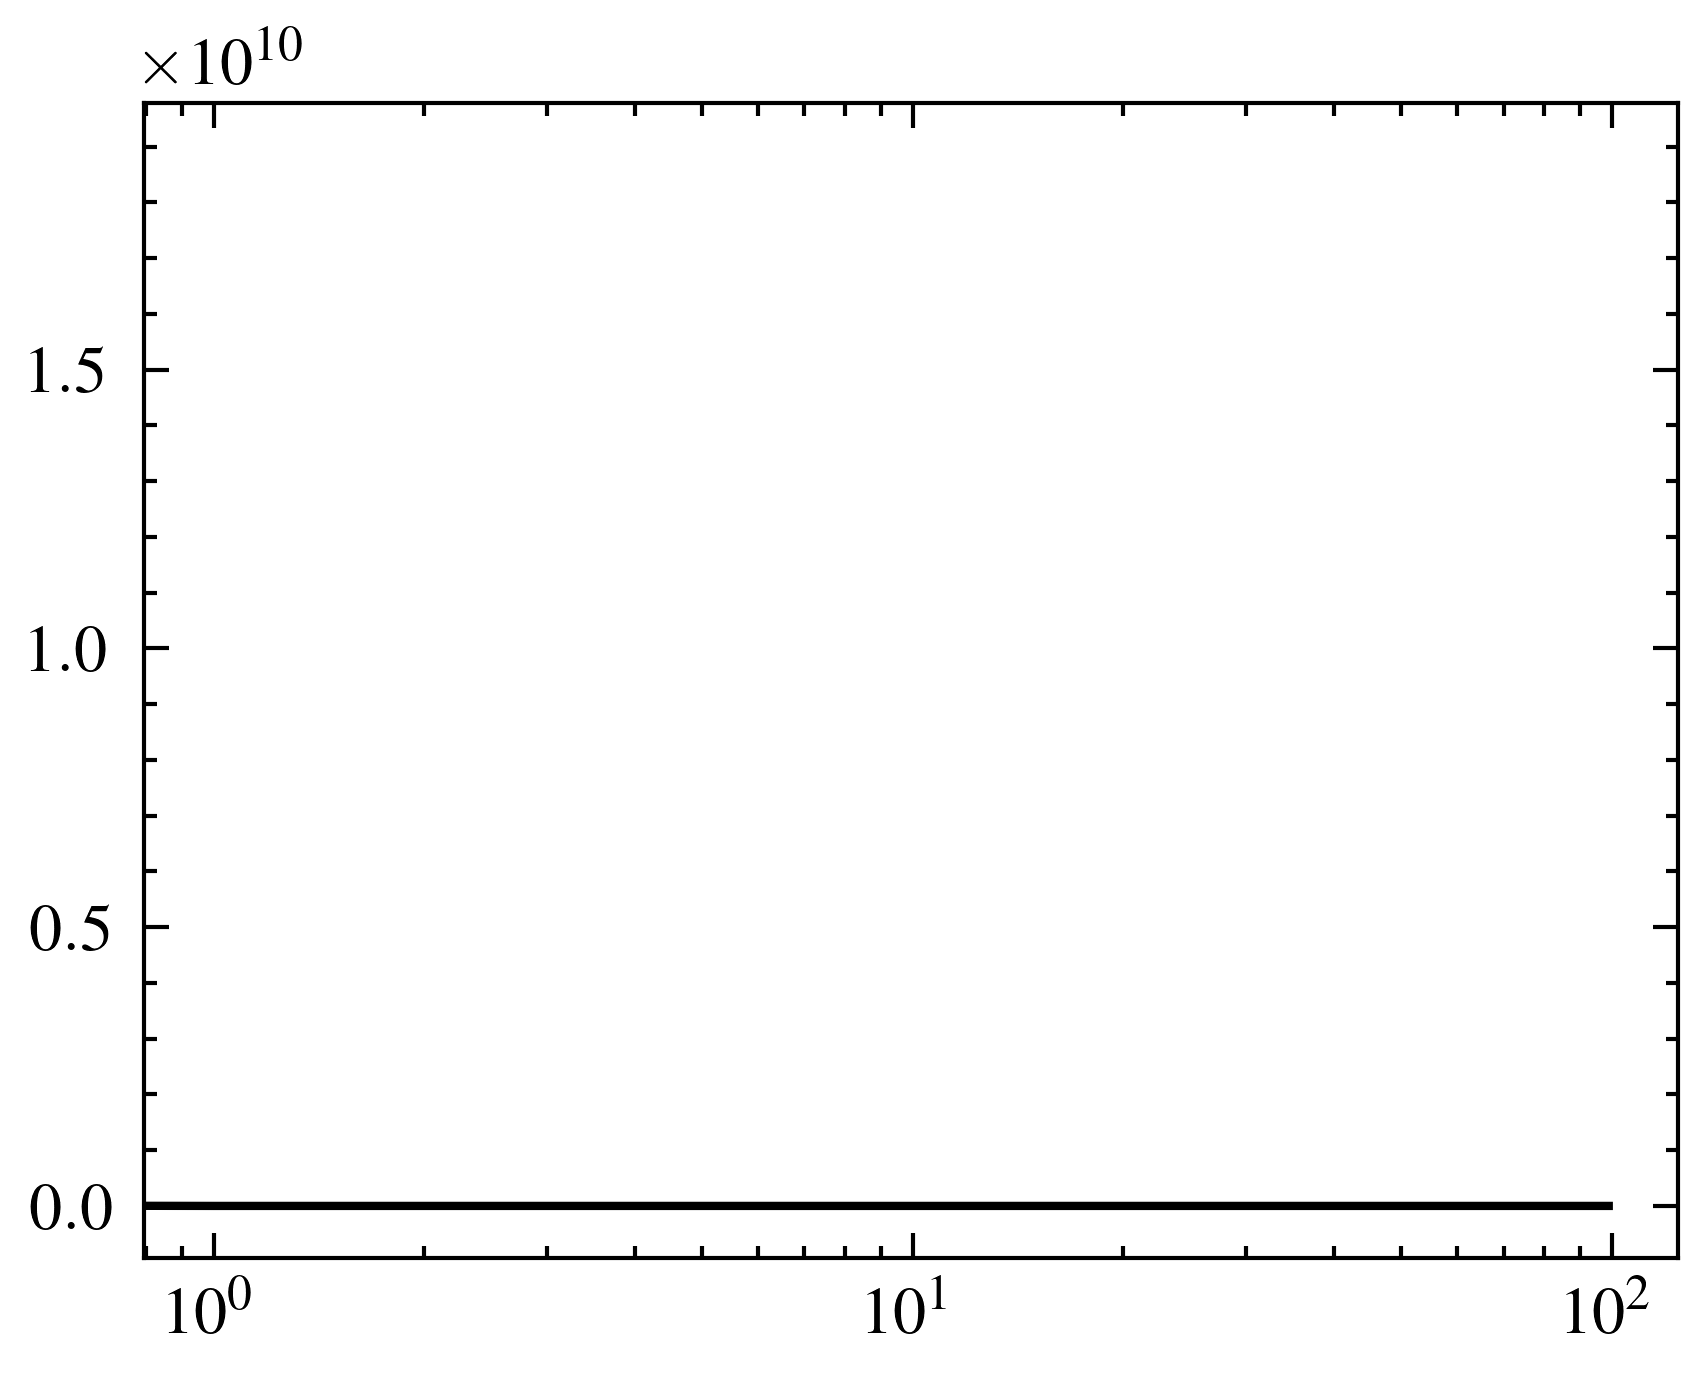

In [15]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(1e-6*sim.dydt_array[2:, :].sum(axis=0)/cluster_physics.unbiased_jump_rate.magnitude)
plt.xscale('log')
#plt.xlim(10,2e5)

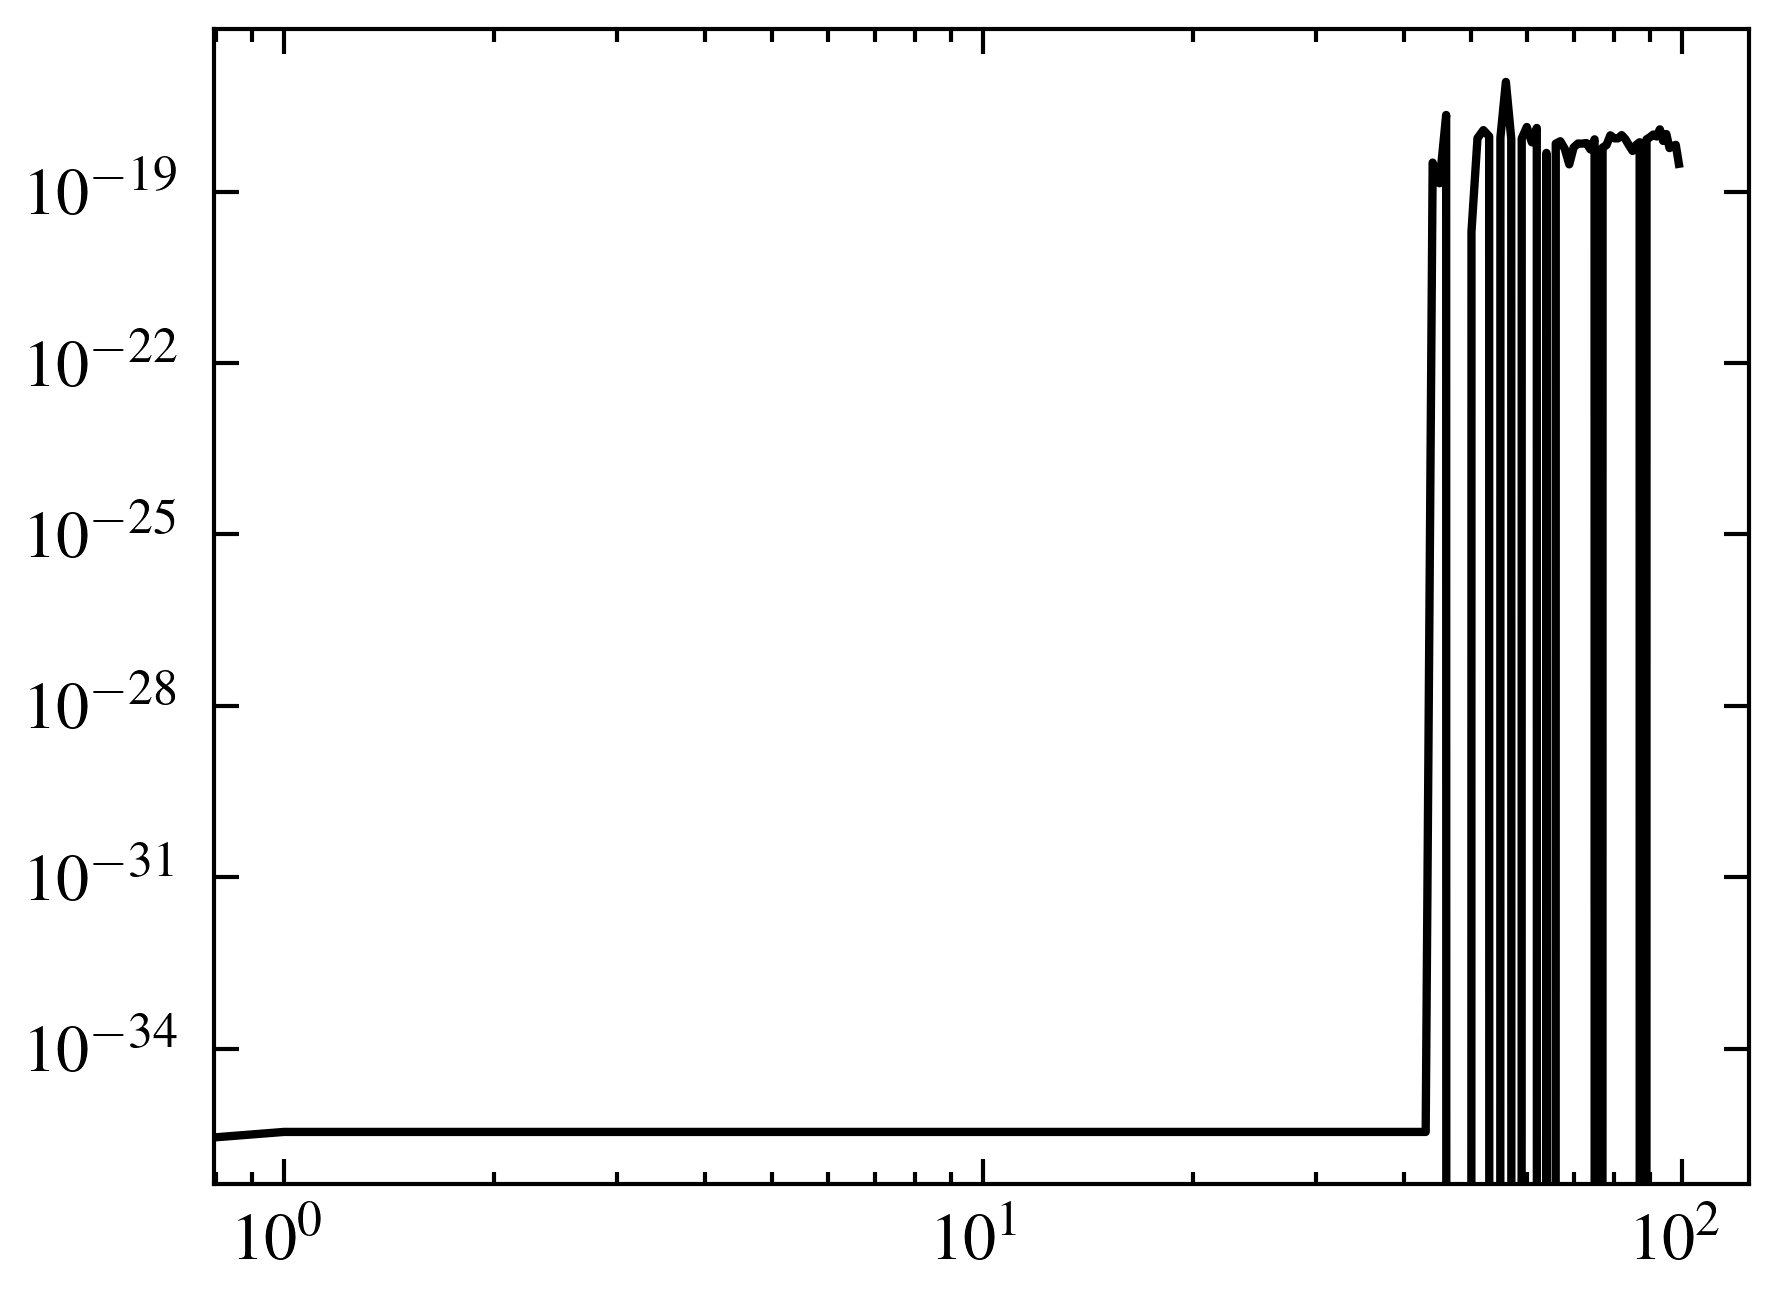

In [16]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.cluster_array[22:, :].sum(axis=0))
plt.xscale('log')
plt.yscale('log')


In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ScipyClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_array[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 0.0337 seconds
Computation time: 0.0521 seconds
Computation time: 0.1762 seconds
Computation time: 1.0776 seconds
Computation time: 29.4072 seconds


/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
/tmp/ipykernel_8295/967383811.py:4: RuntimeWarning: invalid value encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

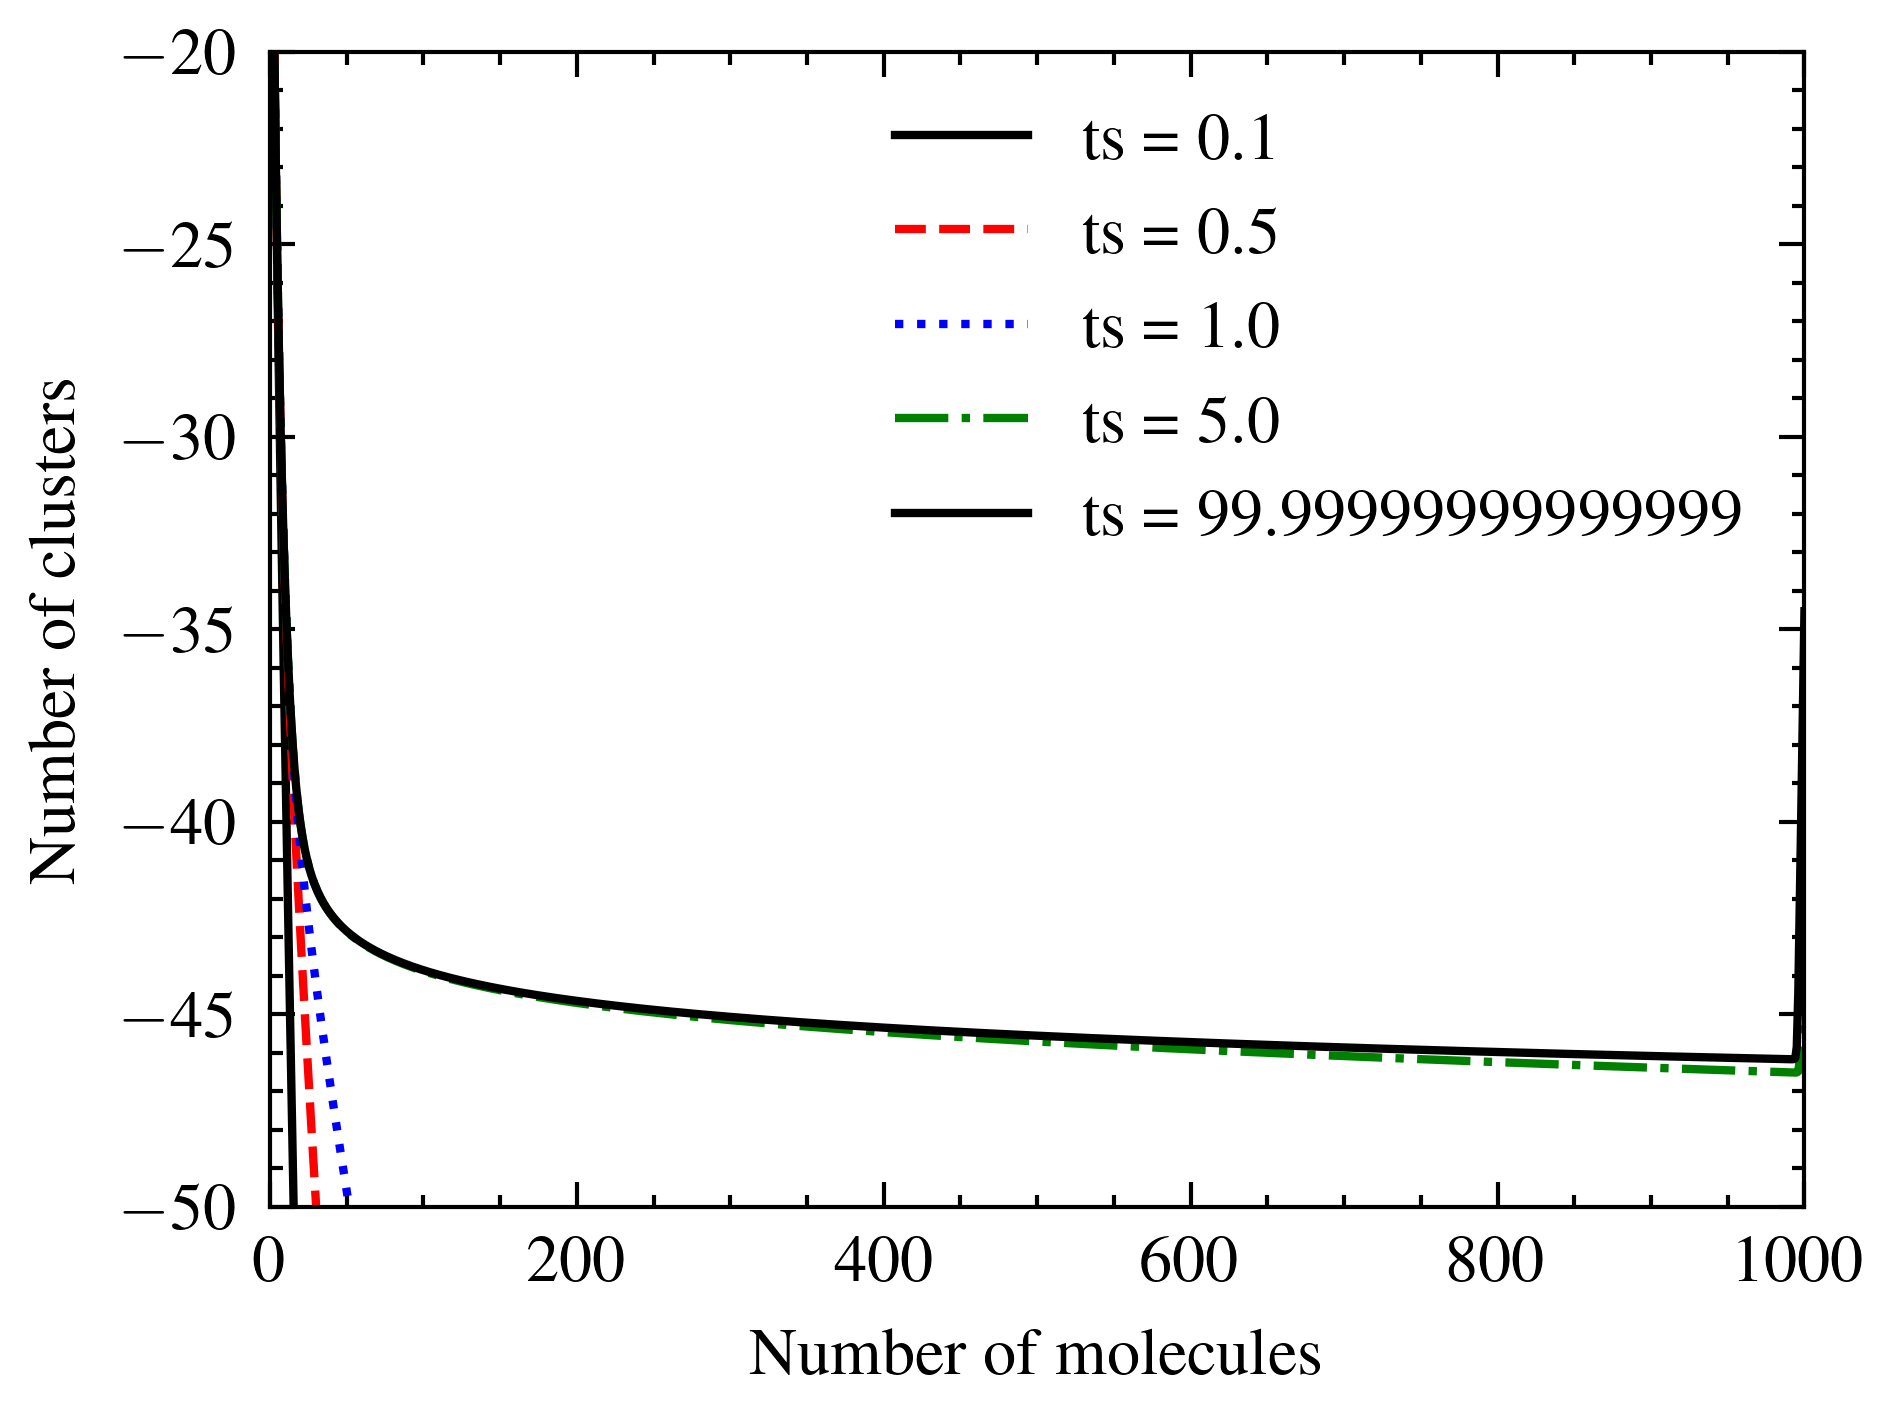

In [6]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [5]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4), int(1e6)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.OpenClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=5)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

Computation time: 1.6886 seconds
Computation time: 0.2698 seconds
Computation time: 0.4434 seconds
Computation time: 2.2021 seconds
Computation time: 33.2245 seconds


/tmp/ipykernel_9375/967383811.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))


(-50.0, -20.0)

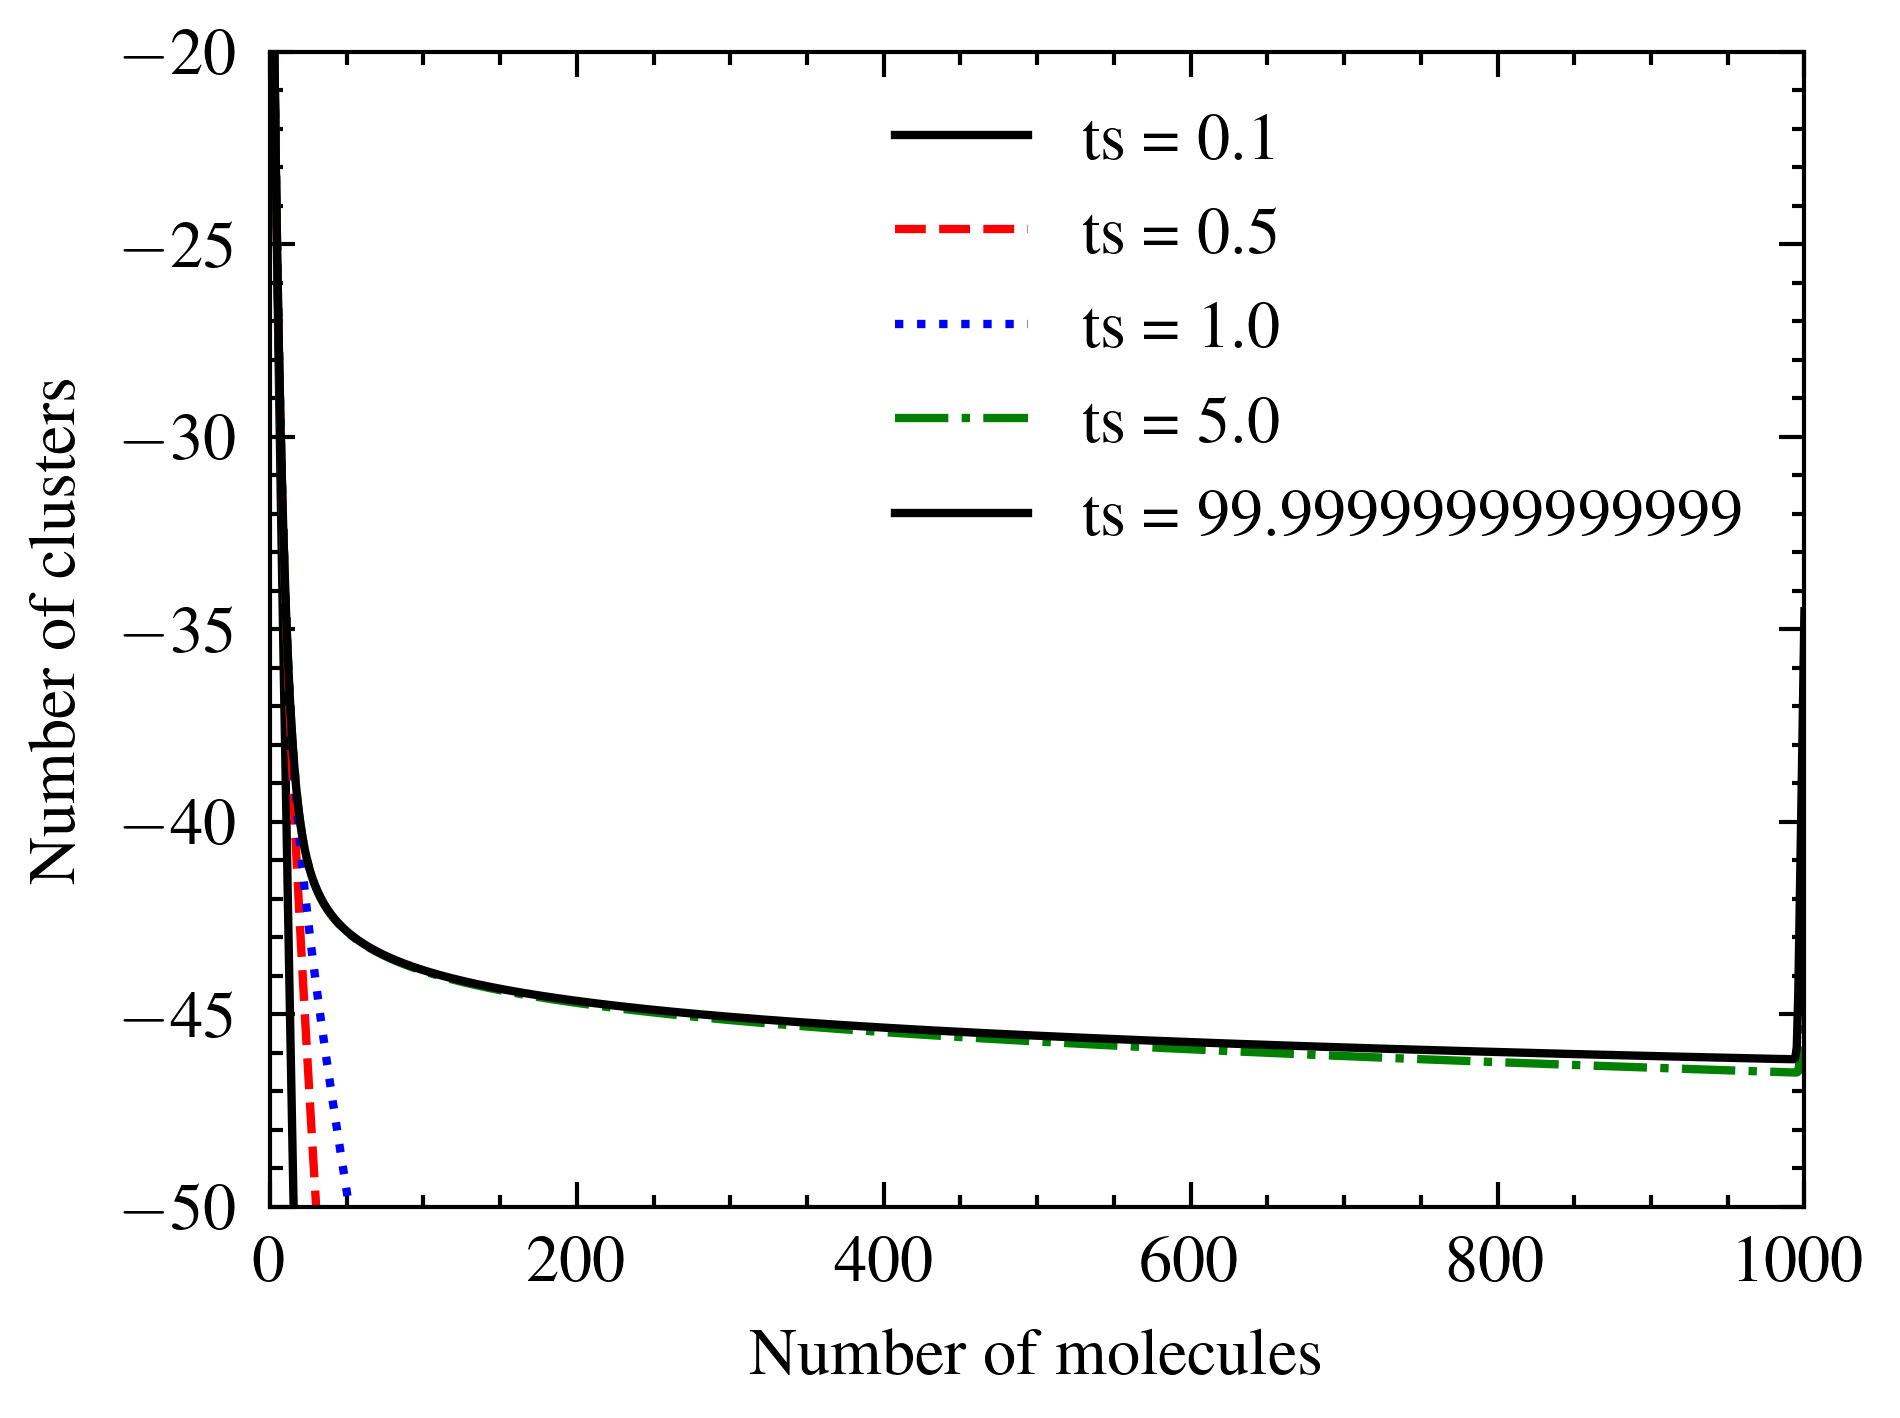

In [8]:
plt.figure()
n = np.linspace(1,1000,1000)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,1000)
plt.ylim(-50,-20)

In [11]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e5)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ClosedClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES, record_frequency=1)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_evolution[:,-1]
    x_array.append(x)
    y_array.append(y)

: 

In [9]:
sim.cluster_evolution

array([[5.85658411e+18, 5.85060004e+18, 5.84661418e+18, ...,
                   nan,            nan,            nan],
       [3.16539427e+16, 3.33864363e+16, 3.45252010e+16, ...,
                   nan,            nan,            nan],
       [2.27490565e+14, 3.95465192e+14, 5.18861415e+14, ...,
                   nan,            nan,            nan],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
                   nan,            nan,            nan]])

(0.0, 10000.0)

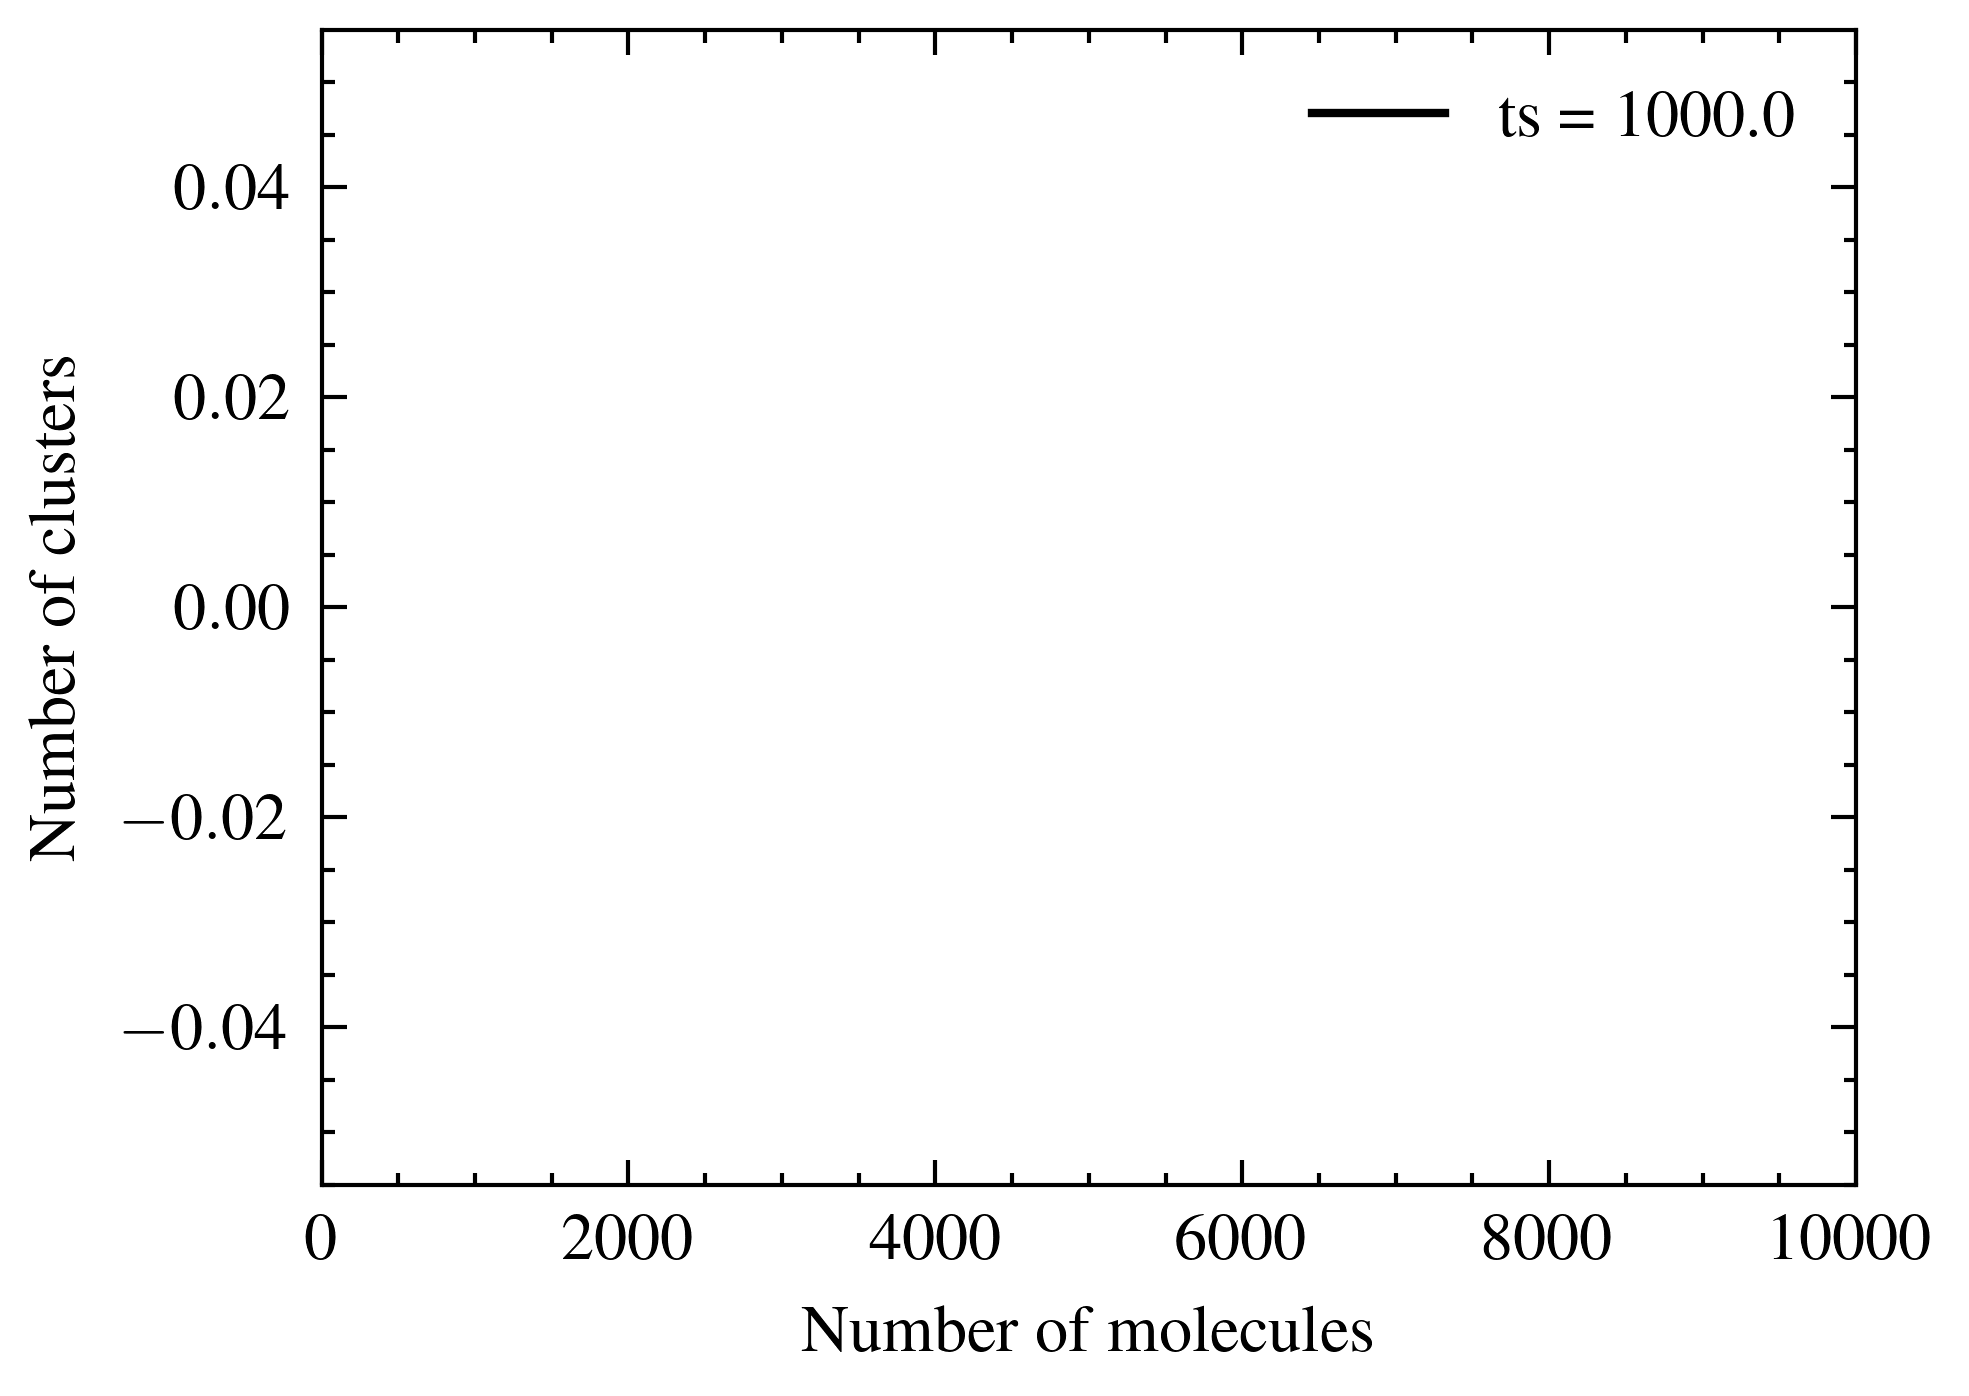

In [8]:
plt.figure()
n = np.linspace(1,100,100)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,10000)
#plt.ylim(-50,-20)

In [7]:
#With Numba 

""" 
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

Computation time: 1.4030 seconds
Computation time: 0.0169 seconds
Computation time: 0.1812 seconds
Computation time: 0.8422 seconds
 """

 # Without Numba
""" 
Computation time: 0.0014 seconds
Computation time: 0.0812 seconds
Computation time: 0.8159 seconds
Computation time: 4.1370 seconds 
"""

' \nComputation time: 0.0014 seconds\nComputation time: 0.0812 seconds\nComputation time: 0.8159 seconds\nComputation time: 4.1370 seconds \n'

In [6]:
steady_state = sim.compute_analytical_steady_state()

(-50.0, -20.0)

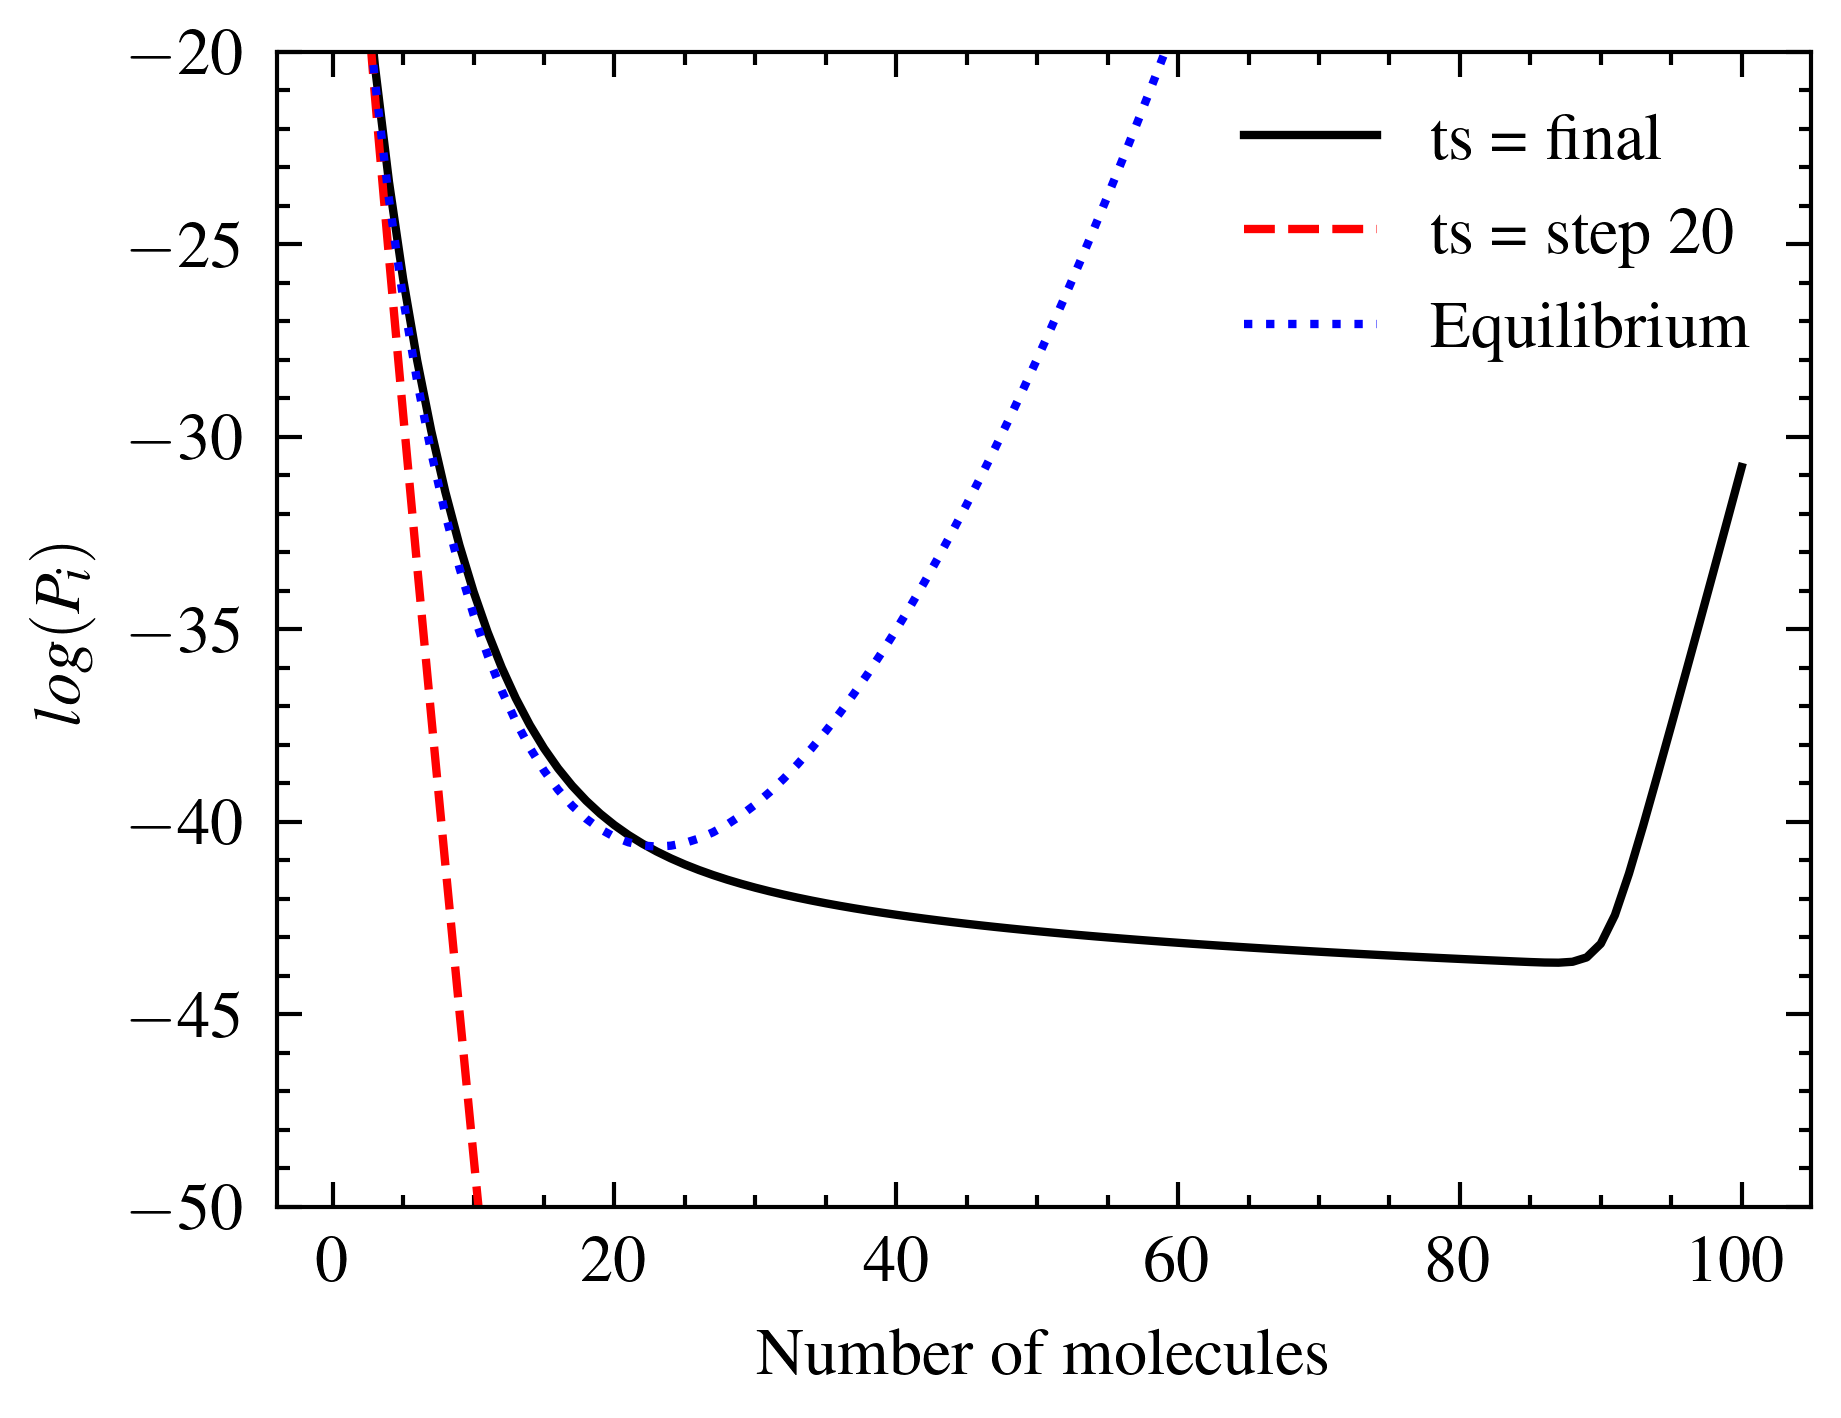

In [8]:

plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_array[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


(-50.0, -20.0)

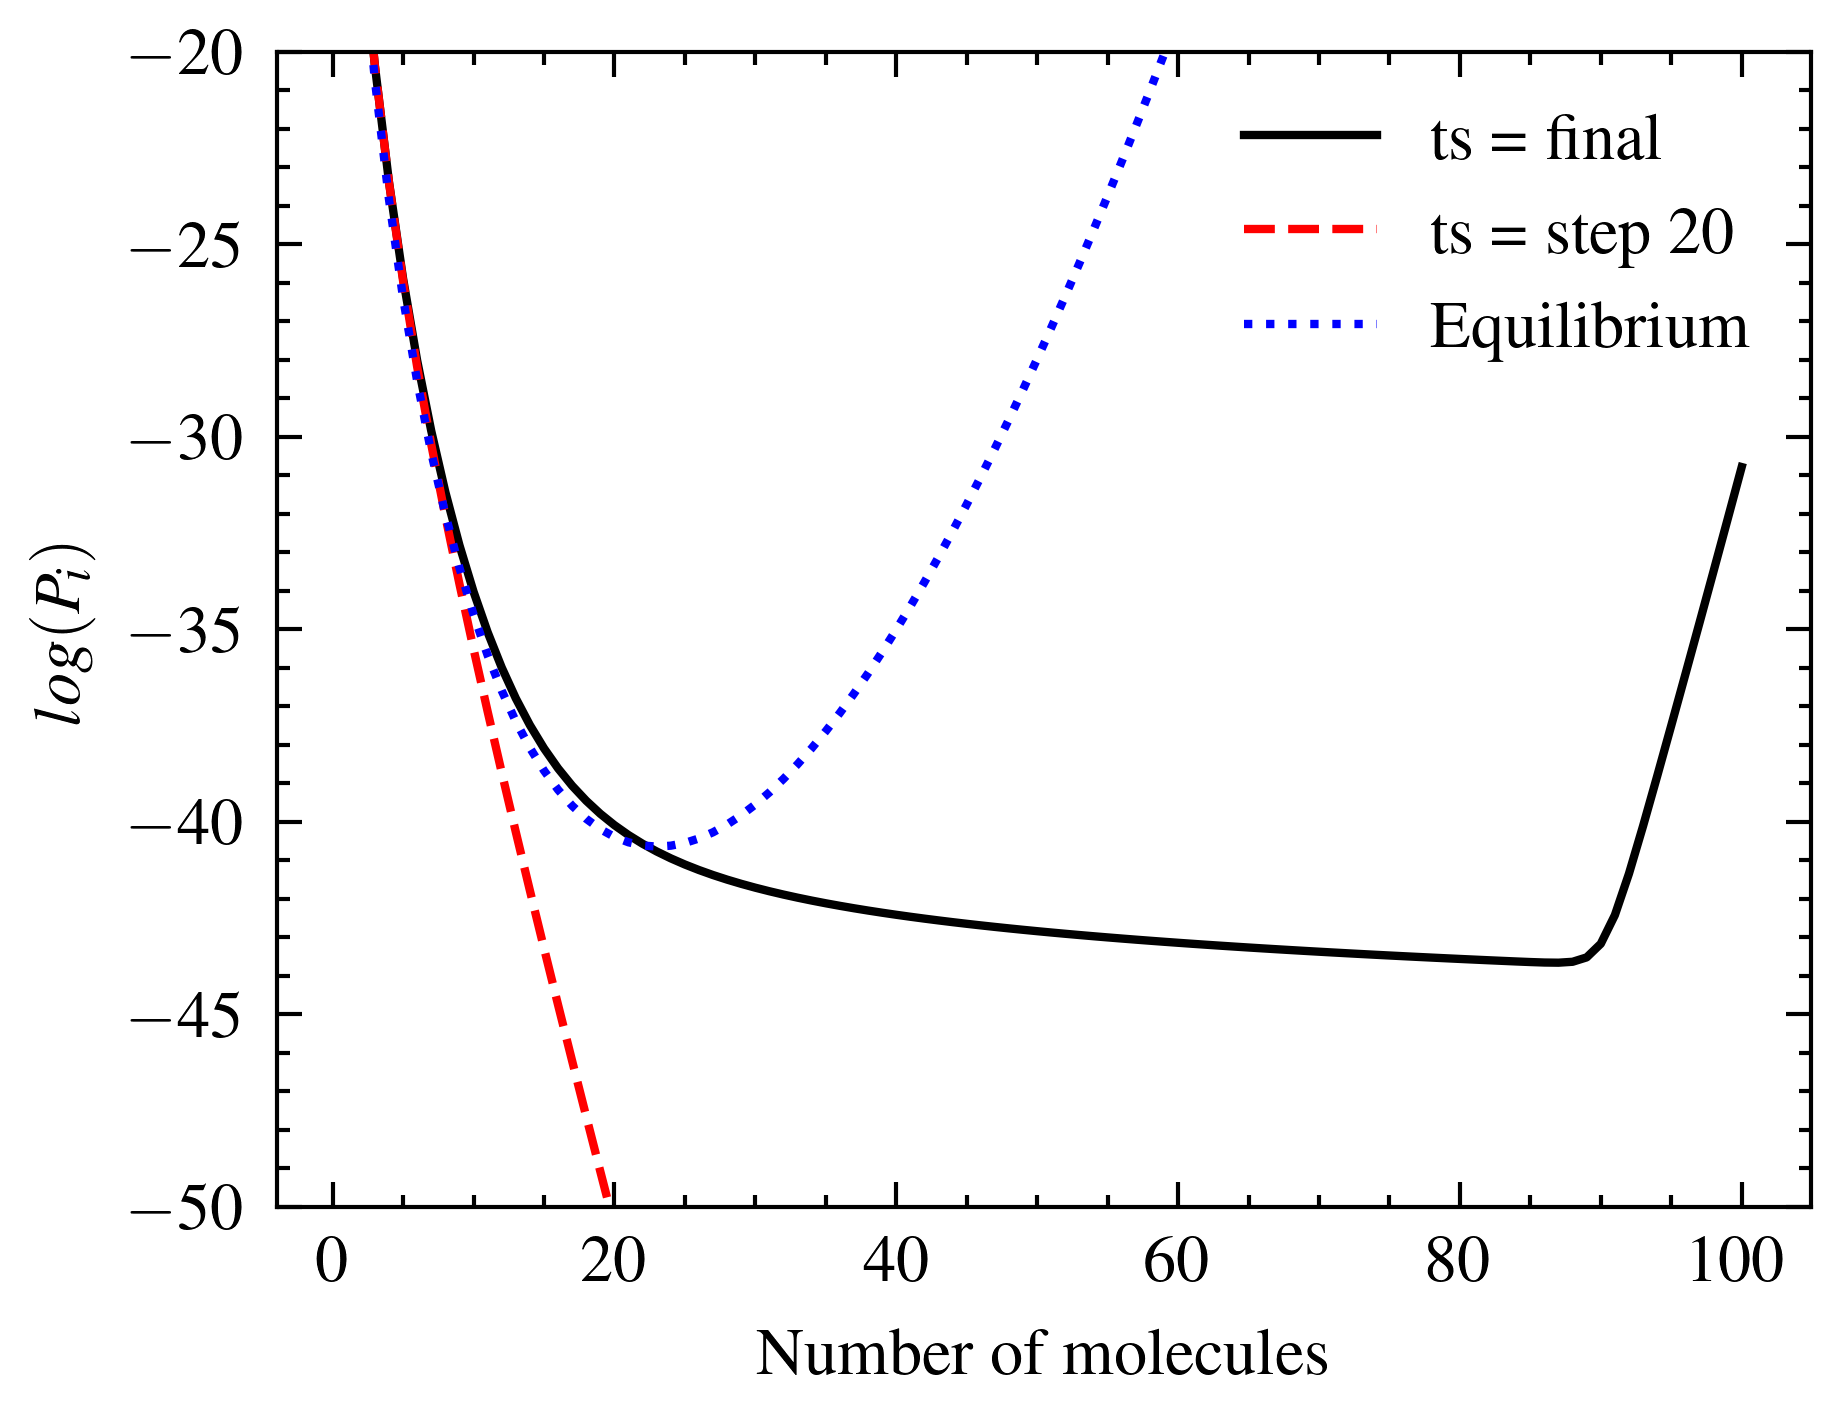

In [6]:
plt.figure()
n = np.linspace(1,100,100)
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim.number_molecules_array,np.log(sim.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


/tmp/ipykernel_31535/2729006377.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')


(-50.0, -20.0)

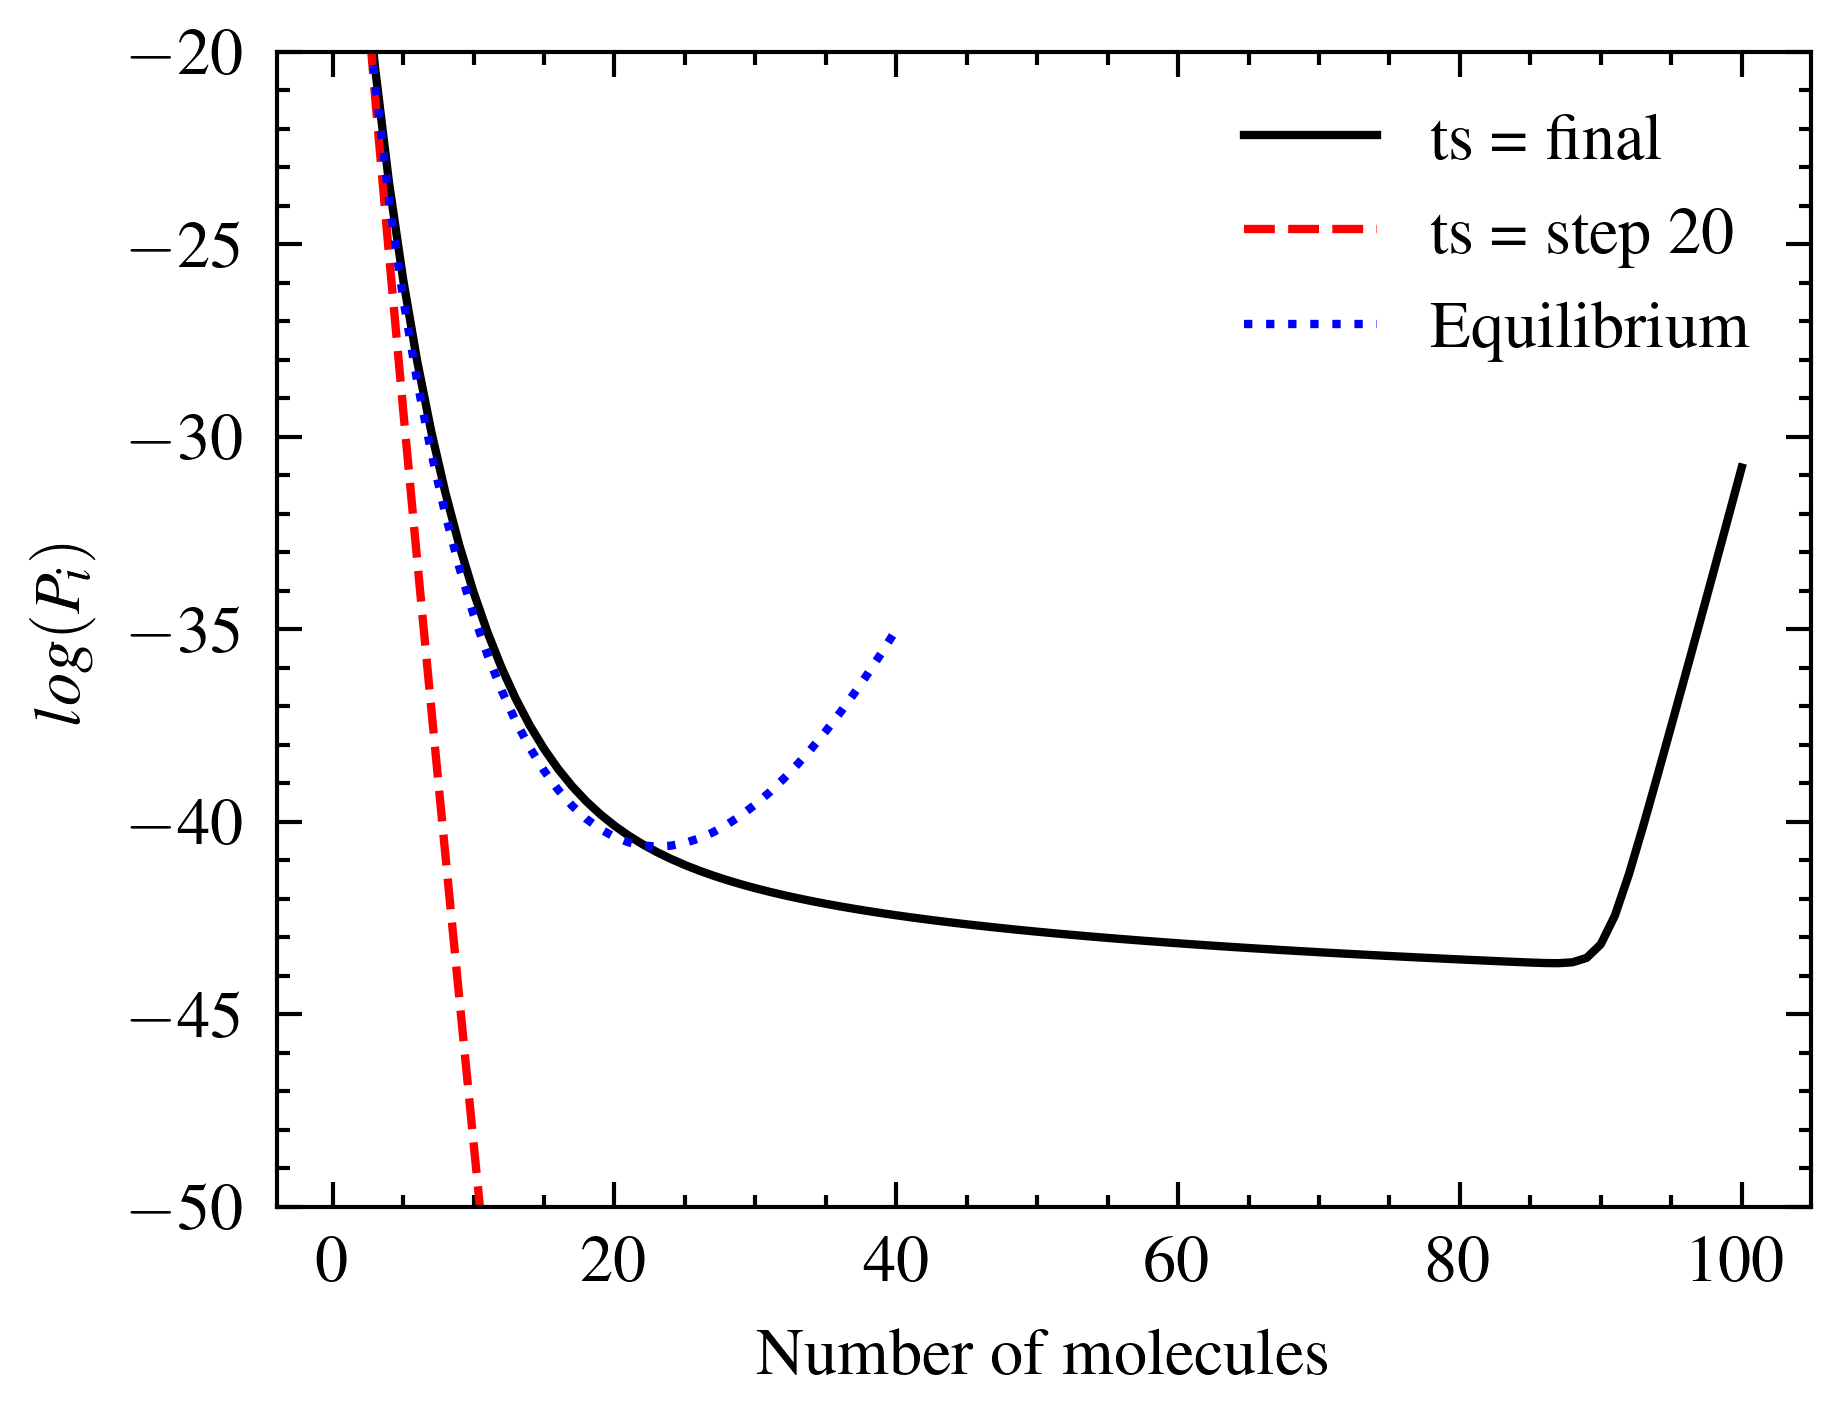

In [8]:
plt.figure()
n = np.linspace(1,40,40)
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,-1]/cluster_physics.AVOGADRO.magnitude), label = 'ts = final')
plt.plot(sim2.number_molecules_array,np.log(sim2.cluster_evolution[:,20]/cluster_physics.AVOGADRO.magnitude), label = 'ts = step 20')
    #plt.plot(x_array[i],np.log(sim.cluster_evolution[:,100]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))

plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel(r'$log(P_i)$')
#plt.xlim(1,MAX_NUMBER_MOLECULES)
plt.ylim(-50,-20)


In [9]:
plt.figure()
plt.plot(sim.cluster_evolution[10,:], label = 'N=9')
plt.plot(sim.cluster_evolution[20,:], label = 'N=19')
plt.plot(sim.cluster_evolution[39,:], label = 'N=40')

plt.legend()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Number of clusters')
plt.show()

: 

In [6]:
sim.cluster_evolution

array([[6.02214090e+23, 6.02214090e+23, 6.02214090e+23, ...,
        6.02214090e+23, 6.02214090e+23, 6.02214090e+23],
       [2.95378152e+21, 2.97098365e+21, 2.98782561e+21, ...,
        3.79638202e+21, 3.79638202e+21, 3.79638202e+21],
       [2.67973215e+16, 1.35676791e+18, 2.66750455e+18, ...,
        8.81199288e+19, 8.81199288e+19, 8.81199288e+19],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

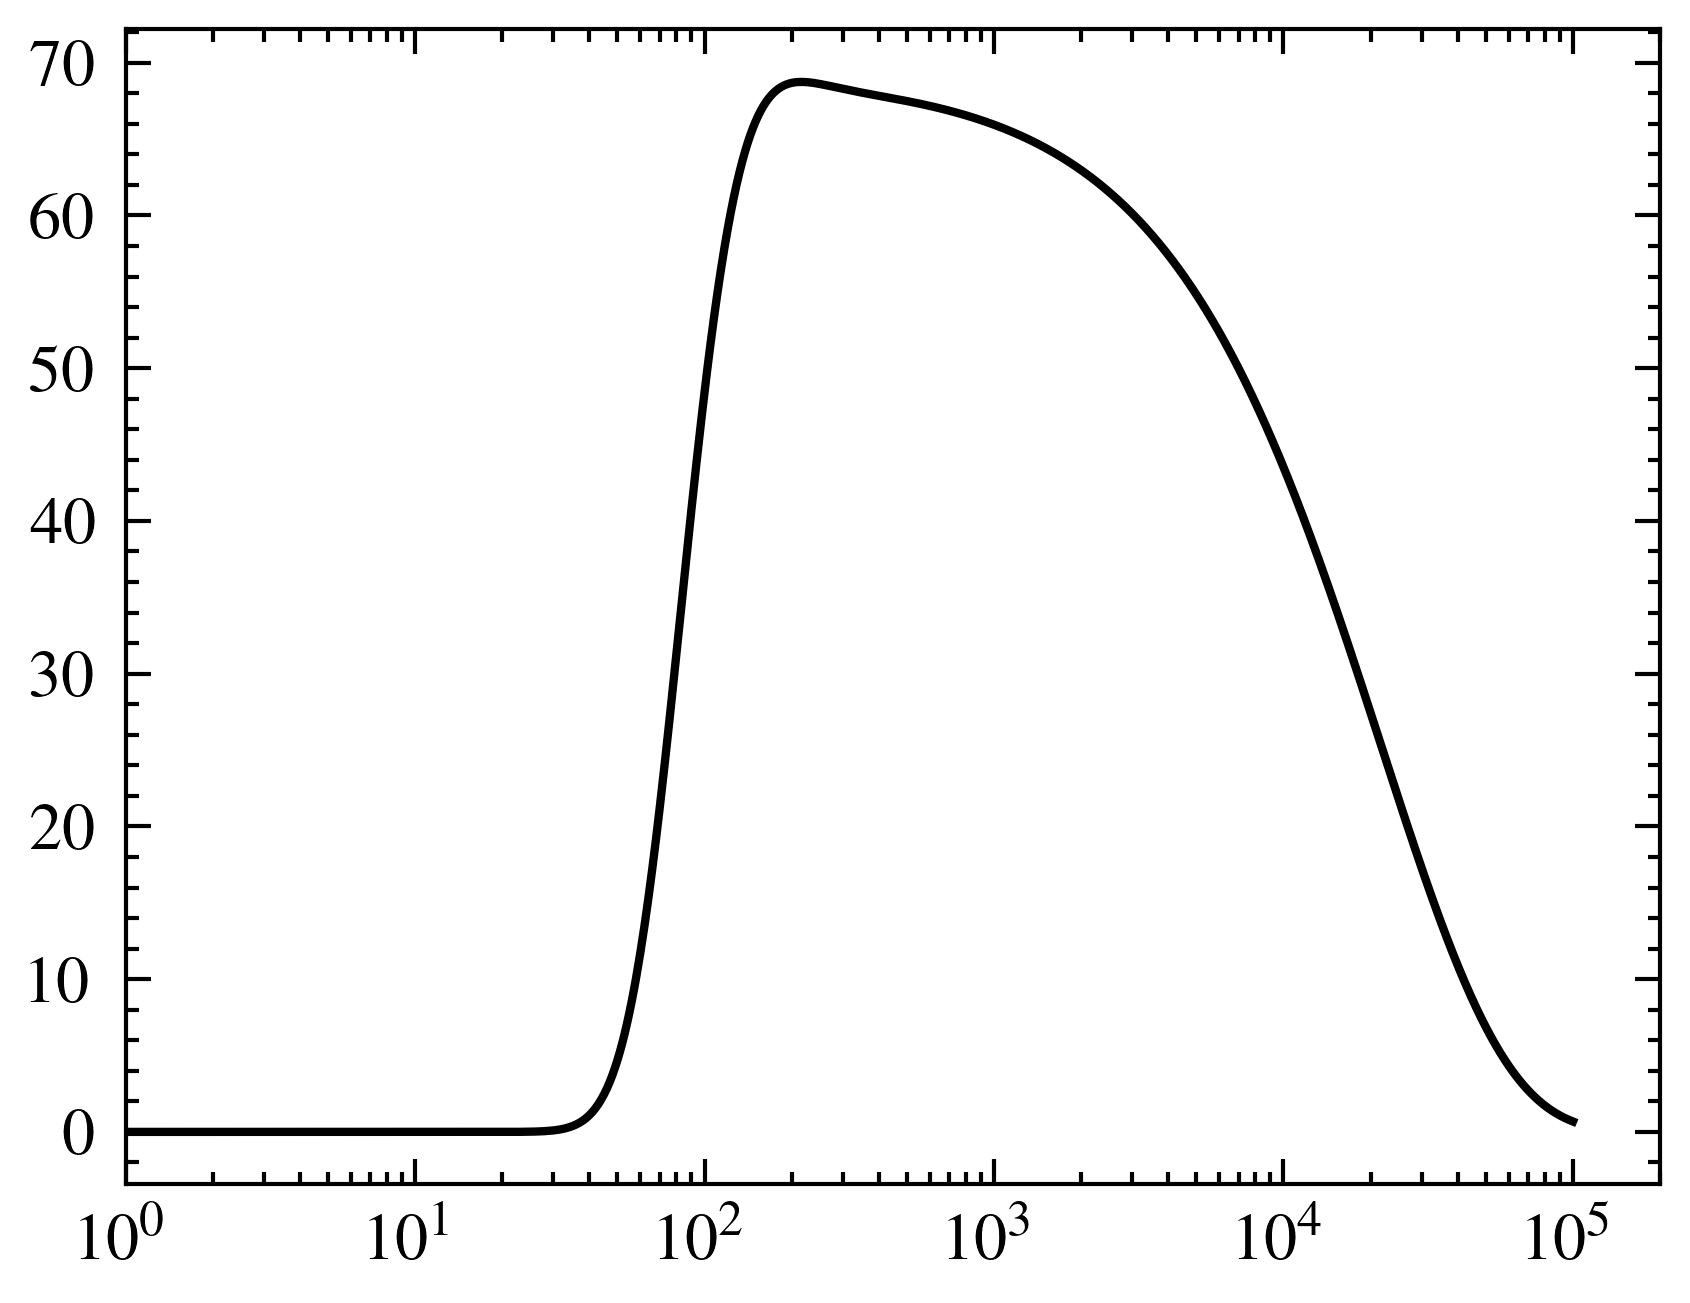

In [40]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(1e-5*sim.rates_evolution[22:, :].sum(axis=0)/cluster_physics.unbiased_jump_rate.magnitude)
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
#plt.yscale('log')
plt.xlim(1,2e5)
plt.xscale('log')
#plt.yscale('log')
#plt.yscale('log')

(100000.0, 10000000000.0)

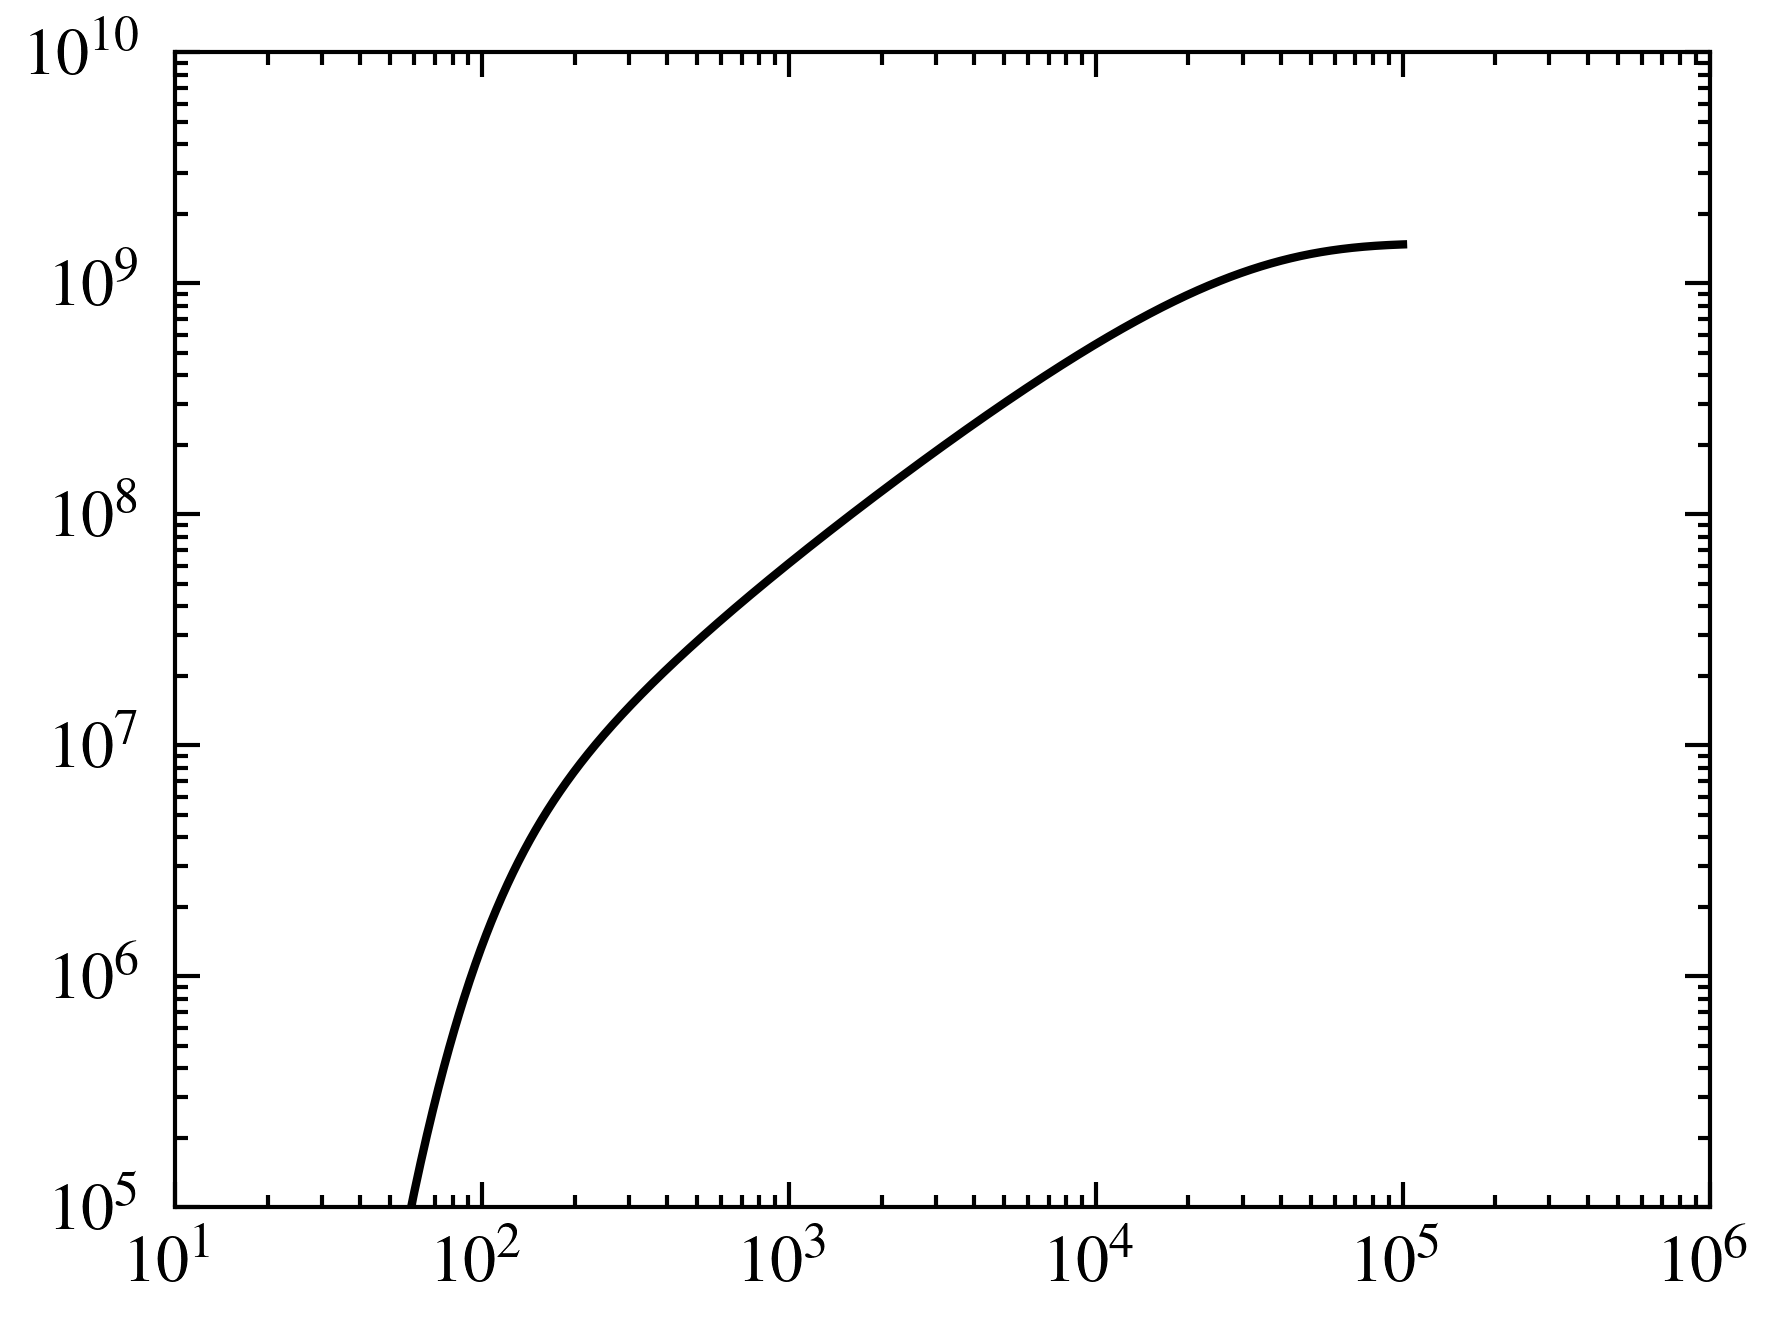

In [41]:
plt.figure()
#plt.plot(sim.rates_evolution.sum(axis=0))
plt.plot(sim.cluster_evolution[22:, :].sum(axis=0))
#plt.axhline(y = steady_state, color = 'green', linestyle = '--')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,1e6)
plt.ylim(1e5,1e10)
#plt.yscale('log')
#plt.yscale('log')

In [12]:
suma_t = sim.rates_evolution.sum(axis=0)

# 'suma_t' es ahora un array con la suma de los valores para cada paso de tiempo
print(suma_t)

[4.18813201e-07 4.17950160e-07 4.17088943e-07 ... 8.66019096e-09
 8.64450195e-09 8.62884253e-09]


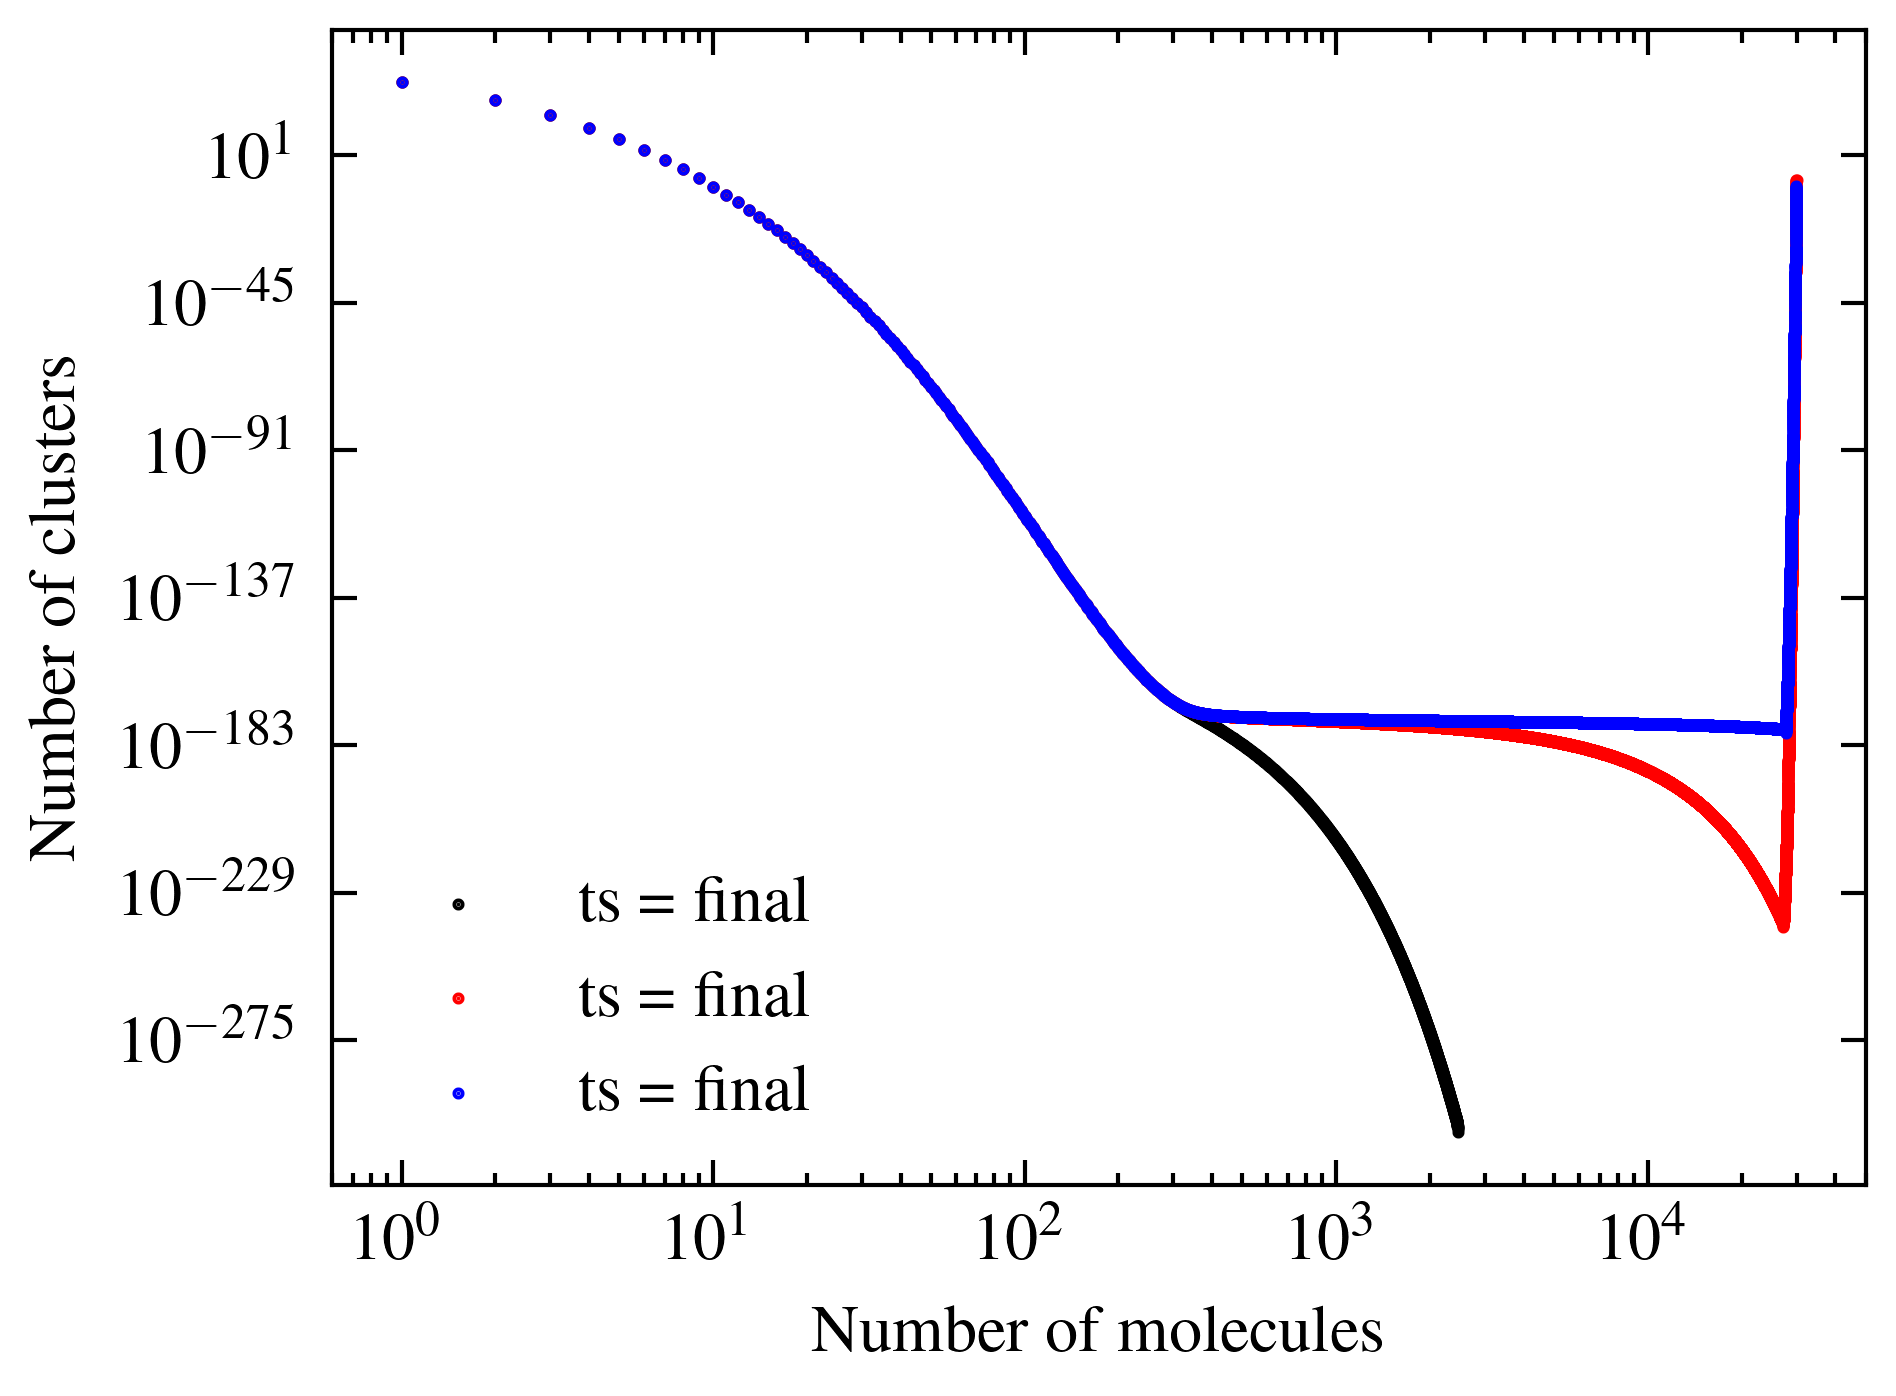

In [73]:
plt.figure()
n = np.linspace(1,500,500)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,10]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,30]), label = 'ts = final', s=0.2)
plt.scatter(sim.number_molecules_array,(sim.cluster_array[:,-1]), label = 'ts = final', s=0.2)
#plt.plot(n,(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xscale('log')
plt.yscale('log')

